In [3]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius, kerr_circ_geo_orbital_frequency

import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
mpl.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
mpl.rc('text', usetex=True)
mpl.rc('font', **{'size' : 14})

In [4]:
import os
# pathname = os.path.dirname(os.path.abspath(__file__))

OMEGA_MIN = 2.e-3
A_MAX = 0.9999

def alpha_of_a_omega(a, omega):
    oISCO = kerr_isco_frequency(a)
    return alpha_of_omega_ISCO(omega, oISCO)

def alpha_of_omega_ISCO(omega, oISCO):
    return (abs(oISCO**(1./3.) - omega**(1./3.))/(oISCO**(1./3.) - OMEGA_MIN**(1./3.)))**(0.5)

def omega_of_a_alpha(a, alpha):
    oISCO = kerr_isco_frequency(a)
    return omega_of_alpha_ISCO(alpha, oISCO)

def omega_of_alpha_ISCO(alpha, oISCO):
    return pow(pow(oISCO, 1./3.) - pow(alpha, 2.)*(pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.)), 3.)

def chi_of_spin_subfunc(a):
    return pow(1. - a, 1./3.)

def chi_of_spin(a):
    return pow((chi_of_spin_subfunc(a) - chi_of_spin_subfunc(A_MAX))/(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 0.5)

def spin_of_chi(chi):
    return 1. - pow(chi_of_spin_subfunc(A_MAX) + pow(chi, 2.)*(chi_of_spin_subfunc(-A_MAX) - chi_of_spin_subfunc(A_MAX)), 3.)

def a_omega_to_chi_alpha(a, omega):
    chi = chi_of_spin(a)
    alpha = alpha_of_a_omega(a, omega)
    return (chi, alpha)

traj = np.loadtxt("../data/trajectory.txt", skiprows=3)
trajHeader = np.loadtxt("../data/trajectory.txt", skiprows=2, max_rows=1, dtype='str')
trajShape = np.loadtxt("../data/trajectory.txt", skiprows=1, max_rows=1, dtype='int')

phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape))
timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape))
fluxData = np.ascontiguousarray(traj[:, 2].reshape(trajShape))
chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])
alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])

Edot = BicubicSpline(chiData, alphaData, fluxData, bc = "E(3)")
PhiCheck = BicubicSpline(chiData, alphaData, phaseData, bc = "E(3)")
TCheck = BicubicSpline(chiData, alphaData, timeData, bc = "E(3)")

downsample_rate = 4
Nb = int((chiData.shape[0] - 1)/downsample_rate + 1)
Na = int((alphaData.shape[0] - 1)/downsample_rate + 1)
flux_samples = np.zeros((Nb, Na, 5))
phase_samples = np.zeros((Nb, Na, 5))
time_samples = np.zeros((Nb, Na, 5))
for i in range(Nb):
    for j in range(Na):
        chi = chiData[downsample_rate*i]
        alpha = alphaData[downsample_rate*j]
        atemp = spin_of_chi(chi)
        otemp = omega_of_a_alpha(atemp, alpha)
        EdotData = Edot(chi, alpha)
        PData = PhiCheck(chi, alpha)
        TData = TCheck(chi, alpha)
        flux_samples[i, j] = [atemp, otemp, EdotData, alpha, chi]
        phase_samples[i, j] = [atemp, otemp, PData, alpha, chi]
        time_samples[i, j] = [atemp, otemp, TData, alpha, chi]

cmap_temp = mpl.colormaps['plasma'].resampled(80)
alist = [0, 14, 20, 25, 29, 32]

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    plt.plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E^N$')
plt.legend()
plt.show()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    plt.plot(alphas, EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$\mathcal{F}_E$')
plt.legend()
plt.show()

# for i in [0, 10, 14, 22, 26, 30, 32]: 
#     avals, omegas, EdotVals = flux_samples[i].T
#     EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
#     plt.plot(omegas, EdotVals_reweighted, label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('$\hat{\Omega}$')
# plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
# plt.savefig(pathname+"/../figures/trajectory_a_omega.pdf", bbox_inches="tight", dpi=300)

AttributeError: 'ListedColormap' object has no attribute 'resampled'

In [5]:
for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    plt.plot(omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\hat{\Omega}$')
plt.ylabel('$\mathcal{F}_E$')
# plt.legend()
plt.show()

NameError: name 'alist' is not defined

In [6]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    Pvals_shifted = 32*(PVals)*omegas**(5/3)
    alphas, chis = flux_samples[i,:,3:].T
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
    avals, omegas, TVals = time_samples[i,:,:3].T
    Tvals_shifted = 256/5*TVals*(omegas)**(8/3)
    # plt.plot(alphas, np.flip(Tvals_shifted), '--', color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

NameError: name 'alist' is not defined

In [7]:
for i in alist: 
    avals, omegas, PVals = phase_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    Pvals_shifted = PVals*omegas**(5/3)
    plt.plot(alphas, np.flip(Pvals_shifted), label="$a = {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('$\\alpha$')
plt.ylabel('$32\check{\Phi}^N$')
# plt.legend()
plt.show()

NameError: name 'alist' is not defined

NameError: name 'alist' is not defined

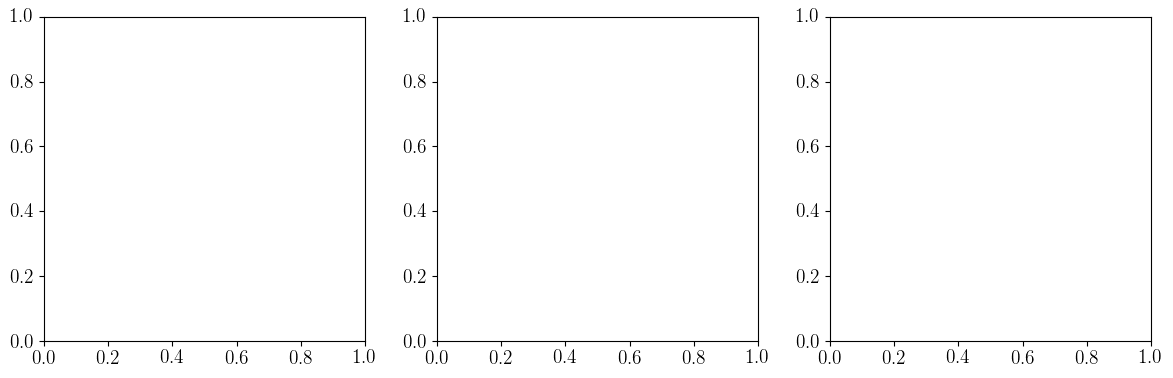

In [8]:
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    axs[0].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    axs[1].plot(omegas[0] - omegas, EdotVals_reweighted, label="$\hat{a}" + "= {:.4}$".format(avals[0]), color=cmap_temp(2*i), lw=2)
axs[1].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in alist: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    axs[2].plot(alphas, 32./5.*EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(2*i), lw=2)
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

NameError: name 'cmap_temp' is not defined

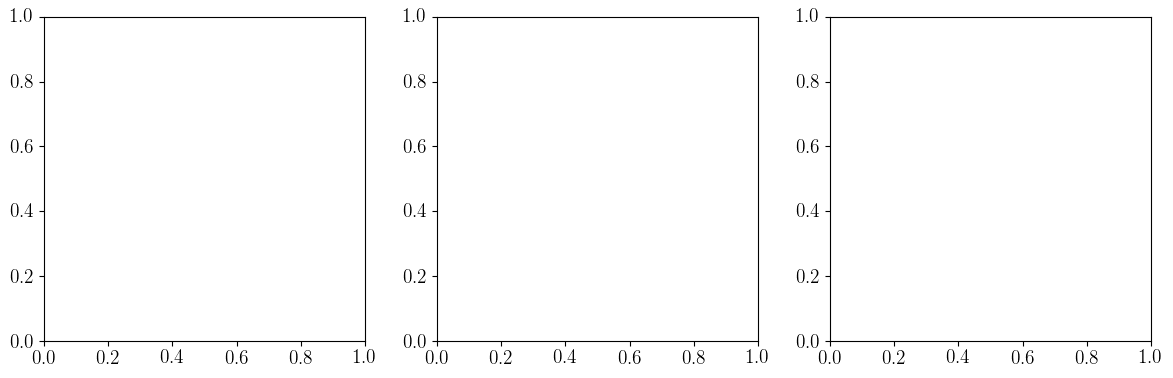

In [9]:
alistHighSpin = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals*omegas**(10/3)
    axs[0].plot(omegas[0] - omegas, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(1-avals[0]), color=cmap_temp(6*i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    EdotVals_reweighted = 32./5.*EdotVals
    axs[1].plot(omegas[0] - omegas, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(1-avals[0]), color=cmap_temp(6*i), lw=2)
axs[1].set_xlabel('$\hat{\Omega}_\mathrm{ISCO} - \hat{\Omega}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in alistHighSpin: 
    avals, omegas, EdotVals = flux_samples[i,:,:3].T
    alphas, chis = flux_samples[i,:,3:].T
    axs[2].plot(alphas, 32./5.*EdotVals, label="$\\chi = {:.4}$".format(chis[0]), color=cmap_temp(6*i), lw=2)
axs[2].set_xlabel('$\\alpha$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

NameError: name 'cmap_temp' is not defined

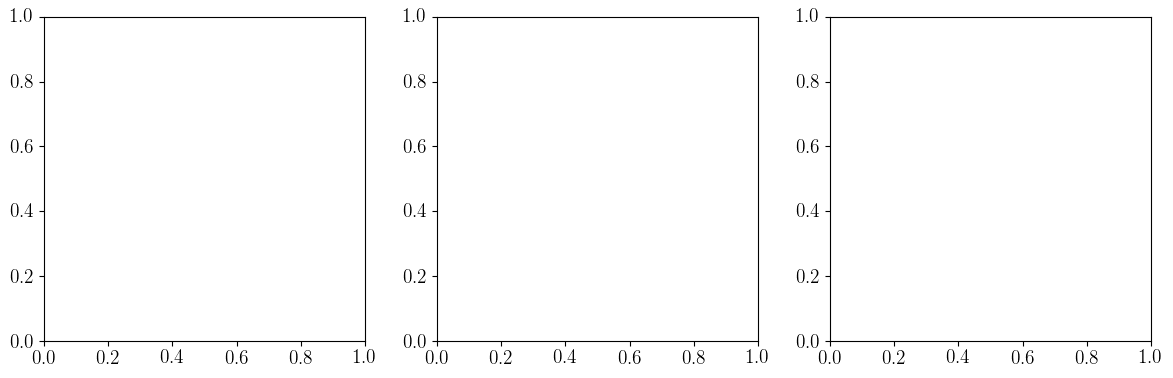

In [10]:
olist = np.array([0, 18, 31, 45, 55, 64])
fig, axs = plt.subplots(1, 3,)
fig.set_size_inches(12, 4)
fig.tight_layout()
for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    EdotVals_reweighted = EdotVals*omegas**(10/3)
    axs[0].plot(1-avals, EdotVals_reweighted, label="$1-\hat{a}" + "= {:.4}$".format(omegas[0]), color=cmap_temp(i), lw=2)
# plt.xscale('log')
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xlabel('$1 - \hat{a}$')
axs[0].set_ylabel('$\mathcal{F}_E$')

for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    EdotVals_reweighted = EdotVals
    axs[1].plot(1 - avals, EdotVals_reweighted, label="$\hat{\Omega}" + "= {:.4}$".format(omegas[0]), color=cmap_temp(i), lw=2)
axs[1].set_xscale('log')
axs[1].set_xlabel('$1 - \hat{a}$')
axs[1].set_ylabel('$\mathcal{F}_E^N$')
axs[1].legend()

for i in olist: 
    avals, omegas, EdotVals = flux_samples[:,i,:3].T
    alphas, chis = flux_samples[:,i,3:].T
    axs[2].plot(chis, EdotVals, label="$\\alpha = {:.4}$".format(alphas[0]), color=cmap_temp(i), lw=2)
axs[2].set_xlabel('$\\chi$')
axs[2].set_ylabel('$\mathcal{F}_E$')
axs[2].legend()
plt.show()

# Check accuracy of splines

In [11]:
# from scipy.interpolate import interp2d

# EdotDataComp=np.load("/Users/znasipak/Documents/Projects/EccentricFluxes/data/bhpwave_edot_redo.npy")
# alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
# omegaa = omega_of_a_alpha(aa, alphaa)
# fluxData = 2.*EdotDataComp/(32./5.*omegaa**(10./3.))

# Edot_78 = BicubicSpline(chiData, alphaData, fluxData)
# PhiCheck_78 = BicubicSpline(chiData, alphaData, phaseData)
# TCheck_78 = BicubicSpline(chiData, alphaData, timeData)

# Edot_78_py = interp2d(chiData, alphaData, fluxData.T, kind="cubic")
# PhiCheck_78_py = interp2d(chiData, alphaData, phaseData.T, kind="cubic")
# TCheck_78_py = interp2d(chiData, alphaData, timeData.T, kind="cubic")

# downsample_rate_alpha=2
# downsample_rate_chi=1
# Edot_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_77 = BicubicSpline((chiData[::downsample_rate_chi]), (alphaData[::downsample_rate_alpha]), (timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# Edot_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")
# PhiCheck_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")
# TCheck_77_py = interp2d(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]).T, kind="cubic")

# downsample_rate_alpha=4
# downsample_rate_chi=1
# Edot_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_76 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=8
# downsample_rate_chi=1
# Edot_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_75 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=2
# Edot_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_68 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=4
# Edot_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_58 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=1
# downsample_rate_chi=8
# Edot_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_48 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=2
# downsample_rate_chi=2
# Edot_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=4
# downsample_rate_chi=4
# Edot_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

# downsample_rate_alpha=8
# downsample_rate_chi=8
# Edot_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
# PhiCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
# TCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

In [13]:
from scipy.interpolate import interp2d

EdotDataComp=np.load("../data/bhpwave_edot_redo.npy")
alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
omegaa = omega_of_a_alpha(aa, alphaa)
fluxData = 2.*EdotDataComp/(32./5.*omegaa**(10./3.))

Edot_78 = BicubicSpline(chiData, alphaData, fluxData, bc = "E(3)")
PhiCheck_78 = BicubicSpline(chiData, alphaData, phaseData, bc = "E(3)")
TCheck_78 = BicubicSpline(chiData, alphaData, timeData, bc = "E(3)")

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_67 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_56 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=16
downsample_rate_chi=16
Edot_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_34 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]))
PhiCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]))
TCheck_45 = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]))

bc = 'not-a-knot'

Edot_78_nok = BicubicSpline(chiData, alphaData, fluxData, bc=bc)
PhiCheck_78_nok = BicubicSpline(chiData, alphaData, phaseData, bc=bc)
TCheck_78_nok = BicubicSpline(chiData, alphaData, timeData, bc=bc)

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_67_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_56_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_45_nok = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

bc = 'natural'

Edot_78_nat = BicubicSpline(chiData, alphaData, fluxData, bc=bc)
PhiCheck_78_nat = BicubicSpline(chiData, alphaData, phaseData, bc=bc)
TCheck_78_nat = BicubicSpline(chiData, alphaData, timeData, bc=bc)

downsample_rate_alpha=2
downsample_rate_chi=2
Edot_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_67_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=4
downsample_rate_chi=4
Edot_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_56_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

downsample_rate_alpha=8
downsample_rate_chi=8
Edot_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(fluxData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
PhiCheck_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(phaseData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)
TCheck_45_nat = BicubicSpline(np.ascontiguousarray(chiData[::downsample_rate_chi]), np.ascontiguousarray(alphaData[::downsample_rate_alpha]), np.ascontiguousarray(timeData[::downsample_rate_chi,::downsample_rate_alpha]), bc=bc)

In [14]:
alphaJs = np.linspace(0., 1., 502)
chiIs = np.linspace(0., 1., 502)
error_test=np.array([[abs(1-Edot_67(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test[error_test==0.]=1.e-16
error_test_2=np.array([[abs(1-Edot_56(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_2[error_test_2==0.]=1.e-16
error_test_3=np.array([[abs(1-Edot_45(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_3[error_test_3==0.]=1.e-16
error_test_4=np.array([[abs(1-Edot_34(chiI, alphaJ)/Edot_78(chiI, alphaJ)) for chiI in chiIs] for alphaJ in alphaJs])
error_test_4[error_test_4==0.]=1.e-16
np.max(error_test_2)/np.max(error_test), np.max(error_test_3)/np.max(error_test_2)

(18.47956887452145, 14.62494119454668)

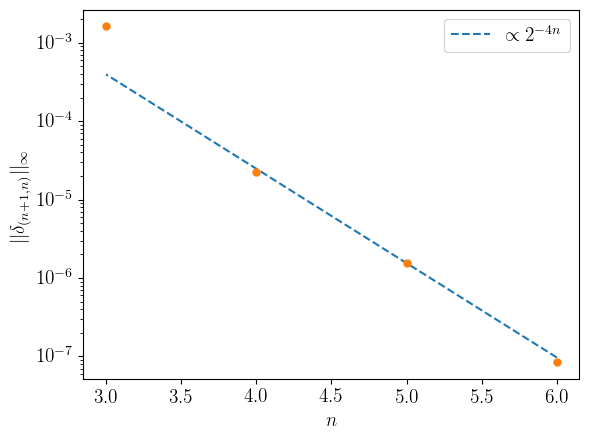

In [21]:
plt.plot([6, 5, 4, 3], [np.max(error_test_2)*2**(4*(5-n)) for n in [6, 5, 4, 3]], '--', label = "$\propto 2^{-4n}$")
plt.plot([6, 5, 4, 3], [np.max(error_test), np.max(error_test_2), np.max(error_test_3), np.max(error_test_4)], '.', markersize=10)
plt.yscale('log')
plt.ylabel('$||\delta_{(n+1,n)}||_\infty$')
plt.xlabel('$n$')
plt.legend()
plt.show()

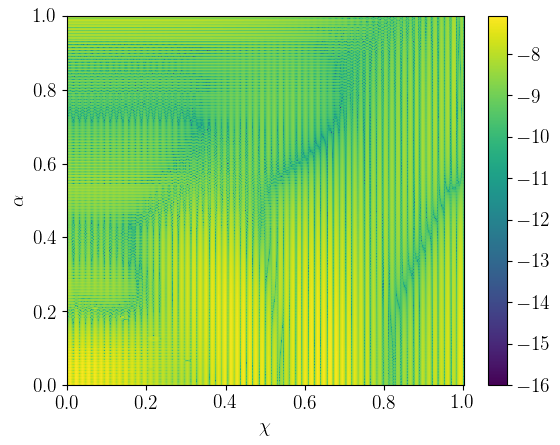

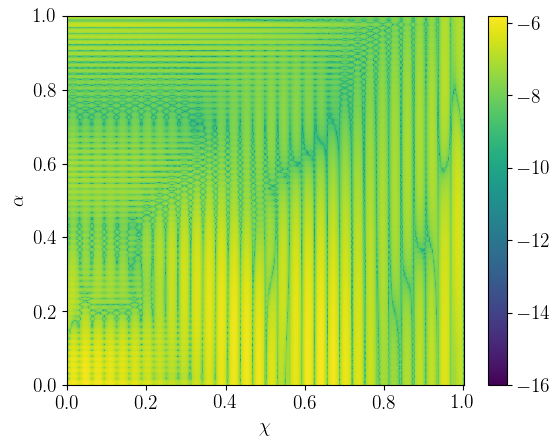

In [22]:
plt.pcolormesh(chiIs, alphaJs, np.log10(error_test), cmap='viridis', shading='auto')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\chi$')
plt.colorbar()
plt.show()
plt.pcolormesh(chiIs, alphaJs, np.log10(error_test_2), cmap='viridis', shading='auto')
plt.ylabel('$\\alpha$')
plt.xlabel('$\\chi$')
plt.colorbar()
plt.show()

# Compare with Toolkit data

In [23]:
from bhpwave.spline import CubicSpline, BicubicSpline
from bhpwave.trajectory.geodesic import kerr_isco_frequency, kerr_circ_geo_radius, kerr_circ_geo_orbital_frequency, kerr_isco_radius

In [24]:
import os 
bhptoolkit_file_location = "https://raw.githubusercontent.com/BlackHolePerturbationToolkit/CircularOrbitSelfForceData/master/Kerr/Fluxes/Flux_Edot_a"
aval_strings = ["-0.99", "-0.8", "-0.5", "0.1", "0.6", "0.9", "0.995", "0.999"]
for aval in aval_strings:
    file_check = "Flux_Edot_a" + aval + ".dat"
    wget_string = "wget " + bhptoolkit_file_location + aval + ".dat"
    print(file_check)
    if not os.path.isfile(file_check):
        os.system(wget_string)

Flux_Edot_a-0.99.dat
Flux_Edot_a-0.8.dat
Flux_Edot_a-0.5.dat
Flux_Edot_a0.1.dat
Flux_Edot_a0.6.dat
Flux_Edot_a0.9.dat
Flux_Edot_a0.995.dat
Flux_Edot_a0.999.dat


In [26]:
EdotDataComp=np.load("../data/bhpwave_edot_redo.npy")
alphaa, aa = np.meshgrid(alphaData, spin_of_chi(chiData))
omegaa = omega_of_a_alpha(aa, alphaa)
spl=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="E(3)")
spl2=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="natural")
spl3=BicubicSpline(np.linspace(0, 1, 129), np.linspace(0, 1, 257), 2.*EdotDataComp/(32./5.*omegaa**(10./3.)), bc="not-a-knot")
def scaled_energy_flux(a, r0, bc="E(3)"):
    omega = kerr_circ_geo_orbital_frequency(a, r0)
    alpha = alpha_of_a_omega(a, omega)
    chi = chi_of_spin(a)
    if bc == "E(3)":
        return spl(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "natural":
        return spl2(chi, alpha)*32./5.*omega**(10./3.)
    elif bc == "not-a-knot":
        return spl3(chi, alpha)*32./5.*omega**(10./3.)
    else:
        return spl(chi, alpha)*32./5.*omega**(10./3.)

In [27]:
flux_file_list = ["../data/Flux_Edot_a0.999.dat", 
                  "../data/Flux_Edot_a0.995.dat", 
                  "../data/Flux_Edot_a0.9.dat", 
                  "../data/Flux_Edot_a0.6.dat", 
                  "../data/Flux_Edot_a0.1.dat", 
                  "../data/Flux_Edot_a-0.5.dat",
                  "../data/Flux_Edot_a-0.8.dat",
                  "../data/Flux_Edot_a-0.99.dat"]
flux_spin_list = [0.999, 0.995, 0.9, 0.6, 0.1, -0.5, -0.8, -0.99]

In [28]:
testData = []
for file, spin in zip(flux_file_list, flux_spin_list):
    tempData = np.loadtxt(file)
    tempData = tempData[tempData[:,0] < 62.]
    testData.append([spin, tempData])

In [29]:
comparisons = []
comparisons2 = []
bc = 'E(3)'
for data in testData:
    a = data[0]
    compData = data[1]
    r_vals = compData[:, 0]
    flux_vals = compData[:, 1] + compData[:, 2]
    flux_comparison = np.zeros((r_vals.shape[0]))
    for i in range(flux_comparison.shape[0]):
        flux_comparison[i] = scaled_energy_flux(a, r_vals[i], bc=bc)
    comparisons.append([r_vals, np.abs(1. - flux_comparison/flux_vals)])
    comparisons2.append([r_vals, np.abs(flux_comparison-flux_vals)])

In [30]:
testData2 = []
for file, spin in zip(flux_file_list[:4], flux_spin_list[:4]):
    tempData = np.loadtxt(file)
    tempData = tempData[tempData[:,0] < 5.]
    testData2.append([spin, tempData])
# testData35 = []
# for file, spin in zip(flux_file_list[:4], flux_spin_list[:4]):
#     tempData = np.loadtxt(file)
#     tempData = tempData[tempData[:,0] < 3.5]
#     tempData = tempData[tempData[:,0] > 2.5]
#     tempData = tempData[tempData[:,1] < 1.]
#     testData35.append([spin, tempData])

In [31]:
comparisons3 = []
bc_type= "E(3)"
for data in testData2:
    a = data[0]
    compData = data[1]
    r_vals = compData[:, 0]
    flux_vals = compData[:, 1] + compData[:, 2]
    flux_comparison = np.zeros((r_vals.shape[0]))
    for i in range(flux_comparison.shape[0]):
        flux_comparison[i] = scaled_energy_flux(a, r_vals[i], bc = bc_type)
    comparisons3.append([r_vals, np.abs(1. - flux_comparison/flux_vals)])

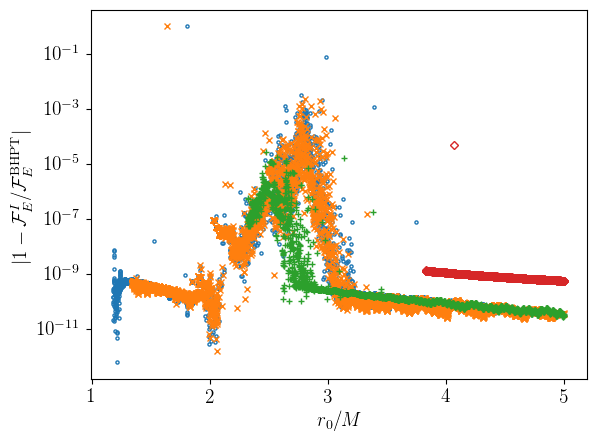

In [32]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
for i, comparison in enumerate(comparisons3):
    plt.plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
plt.yscale('log')
# plt.legend(loc="upper right")
plt.xlabel('$r_0/M$')
plt.ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{BHPT}}|$')
plt.show()

In [34]:
mma_values_900=np.loadtxt("../data/mathetamatica_fluxes_a900.dat")
mma_values_995=np.loadtxt("../data/mathetamatica_fluxes_a995.dat")
mma_values_999=np.loadtxt("../data/mathetamatica_fluxes_a999.dat")

In [35]:
comparison_fluxes = []
bc_type = 'E(3)'
for vals in mma_values_900:
    a, r0, flux, flux_error = vals
    flux_comp = scaled_energy_flux(a, r0, bc = bc_type)
    comparison_fluxes.append([r0, np.abs(1 - flux/flux_comp)])
mma_comp_900 = np.array(comparison_fluxes).T
comparison_fluxes = []
for vals in mma_values_995:
    a, r0, flux, flux_error = vals
    flux_comp = scaled_energy_flux(a, r0, bc = bc_type)
    comparison_fluxes.append([r0, np.abs(1 - flux/flux_comp)])
mma_comp_995 = np.array(comparison_fluxes).T
comparison_fluxes = []
for vals in mma_values_999:
    a, r0, flux, flux_error = vals
    flux_comp = scaled_energy_flux(a, r0, bc = bc_type)
    comparison_fluxes.append([r0, np.abs(1 - flux/flux_comp)])
mma_comp_999 = np.array(comparison_fluxes).T

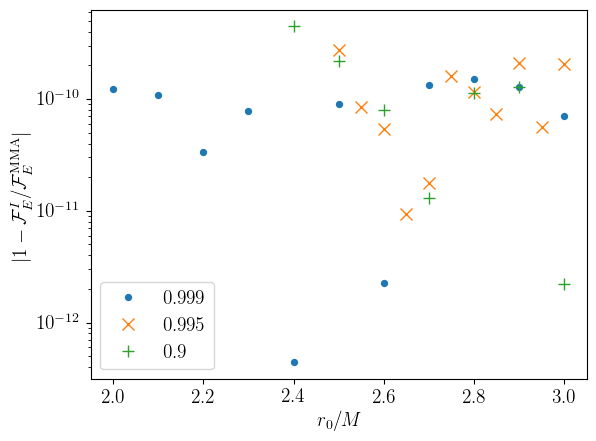

In [36]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']

# for i, comparison in enumerate(comparisons3):
#     plt.plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
plt.plot(mma_comp_999[0], mma_comp_999[1], markers[0], label="$0.999$", markersize = 8.5)
plt.plot(mma_comp_995[0], mma_comp_995[1], markers[1], label="$0.995$", markersize = 8.5)
plt.plot(mma_comp_900[0], mma_comp_900[1], markers[2], label="$0.9$", markersize = 8.5)
plt.yscale('log')
plt.legend(loc="lower left")
plt.xlabel('$r_0/M$')
plt.ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{MMA}}|$')
plt.show()

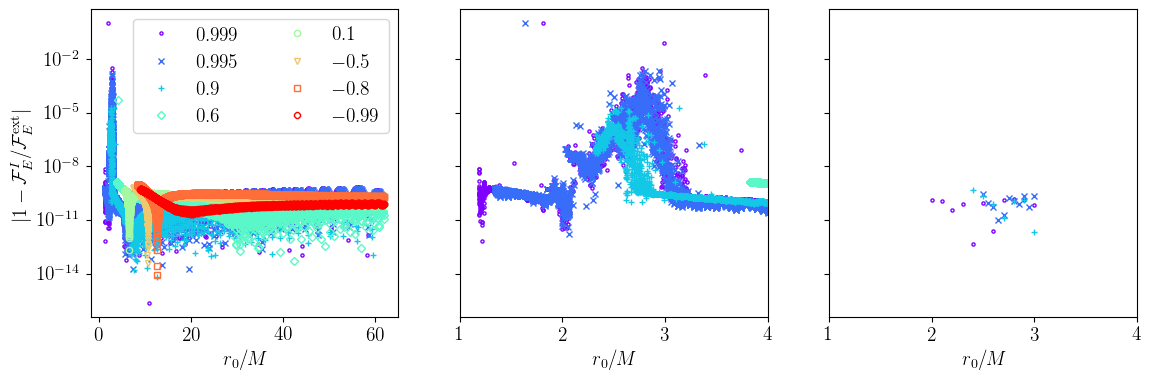

In [38]:
markers = ['.', 'x', '+', 'D', 'o', 'v', 's', '8']
fig, axs = plt.subplots(1,3, sharey=True)
fig.set_size_inches(13.5, 4.)

N = len(markers)
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.rainbow(np.linspace(0,1,N)))

for i, comparison in enumerate(comparisons):
    axs[0].plot(comparison[0][::2], comparison[1][::2], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
axs[0].set_yscale('log')
axs[0].legend(loc="upper right", ncol=2)
axs[0].set_xlabel('$r_0/M$')
axs[0].set_ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{ext}}|$')

for i, comparison in enumerate(comparisons3):
    axs[1].plot(comparison[0], comparison[1], markers[i], label="$"+str(flux_spin_list[i])+"$", markersize = 4.5, fillstyle='none')
axs[1].set_yscale('log')
# plt.legend(loc="upper right")
axs[1].set_xlabel('$r_0/M$')
axs[1].set_xlim(1., 4.)
# axs[1].set_ylabel('$|1 - {\mathcal{F}_E^I}/{\mathcal{F}_E^\mathrm{BHPT}}|$')

axs[2].plot(mma_comp_999[0], mma_comp_999[1], markers[0], label="$0.999$", markersize = 4.5, fillstyle='none')
axs[2].plot(mma_comp_995[0], mma_comp_995[1], markers[1], label="$0.995$", markersize = 4.5, fillstyle='none')
axs[2].plot(mma_comp_900[0], mma_comp_900[1], markers[2], label="$0.9$", markersize = 4.5, fillstyle='none')
axs[2].set_xlim(1., 4.)
axs[2].set_xlabel('$r_0/M$')

# for ax in fig.get_axes():
#     ax.label_outer()

plt.show()

## Test time and phase splines

In [346]:
path_to_bhpwave = "/Users/zachnasipak/Documents/Research/bhpwave/"

traj = np.loadtxt(path_to_bhpwave + "data/trajectory.txt", skiprows=3)
trajHeader = np.loadtxt(path_to_bhpwave + "data/trajectory.txt", skiprows=2, max_rows=1, dtype='str')
trajShape = np.loadtxt(path_to_bhpwave + "data/trajectory.txt", skiprows=1, max_rows=1, dtype='int')

In [382]:
fluxDataTemp = np.ascontiguousarray(traj[:, 2].reshape(trajShape[:2]))
alphaDataFluxTemp = np.ascontiguousarray(traj[:, 1].reshape(trajShape[:2])[0])
chiDataFluxTemp = np.ascontiguousarray(traj[:, 0].reshape(trajShape[:2])[:, 0])

phaseData = np.ascontiguousarray(traj[:, 4].reshape(trajShape[:2]))
timeData = np.ascontiguousarray(traj[:, 3].reshape(trajShape[:2]))
alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape[:2])[0])
chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape[:2])[:, 0])
betaData = np.ascontiguousarray(traj[:, 5].reshape(trajShape[:2])[0])
omegaData = np.ascontiguousarray(traj[:, 6].reshape(trajShape[:2]))
phaseBetaData = np.ascontiguousarray(traj[:, 7].reshape(trajShape[:2]))

In [384]:
fluxDownsampleChi = int((trajShape[0] - 1)/(trajShape[2] - 1))
fluxDownsampleAlpha = int((trajShape[1] - 1)/(trajShape[3] - 1))

fluxData = fluxDataTemp[::fluxDownsampleChi, ::fluxDownsampleAlpha]
alphaDataFlux = alphaDataFluxTemp[::fluxDownsampleAlpha]
chiDataFlux = chiDataFluxTemp[::fluxDownsampleChi]

In [386]:
# traj = np.loadtxt("../data/trajectory_v2.txt", skiprows=3)
# trajHeader = np.loadtxt("../data/trajectory_v2.txt", skiprows=2, max_rows=1, dtype='str')
# trajShape = np.loadtxt("../data/trajectory_v2.txt", skiprows=1, max_rows=1, dtype='int')
# fluxData = np.ascontiguousarray(traj[:, 2].reshape(trajShape))
# alphaDataFlux = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])
# chiDataFlux = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])

# phaseData = -np.ascontiguousarray(traj[:, 4].reshape(trajShape))
# timeData = -np.ascontiguousarray(traj[:, 3].reshape(trajShape))
# alphaData = np.ascontiguousarray(traj[:, 1].reshape(trajShape)[0])
# chiData = np.ascontiguousarray(traj[:, 0].reshape(trajShape)[:, 0])
# betaData = np.ascontiguousarray(traj[:, 5].reshape(trajShape)[0])
# omegaData = np.ascontiguousarray(traj[:, 6].reshape(trajShape))
# phaseBetaData = -np.ascontiguousarray(traj[:, 7].reshape(trajShape))

In [387]:
def pn_flux_noprefactor(omega):
    return omega**(10./3.)

def pn_time_noprefactor(a, omega):
    oISCO = kerr_isco_frequency(a)
    offset = oISCO**(-8/3) + 1.e-6
    return -np.abs(offset - omega**(-8./3.))

def pn_phase_noprefactor(a, omega):
    oISCO = kerr_isco_frequency(a)
    offset = oISCO**(-5/3) - 1.e-6
    return -np.abs(offset - omega**(-5./3.))

# def pn_time_noprefactor(a, omega):
#     oISCO = kerr_isco_frequency(a)
#     offset = 0
#     return -np.abs(offset - omega**(-8./3.))

# def pn_phase_noprefactor(a, omega):
#     oISCO = kerr_isco_frequency(a)
#     offset = 0
#     return -np.abs(offset - omega**(-5./3.))

def pn_flux_noprefactor_domega(omega):
    return (10./3.)*omega**(7./3.)

def pn_time_noprefactor_domega(omega):
    return -(-8/3)*omega**(-11./3.)

def pn_phase_noprefactor_domega(omega):
    return -(-5/3)*omega**(-8./3.)

In [388]:
ALPHA_FLUX, CHI_FLUX = np.meshgrid(alphaDataFlux, chiDataFlux)
SPIN_FLUX = spin_of_chi(CHI_FLUX)
OMEGA_FLUX = omega_of_a_alpha(SPIN_FLUX, ALPHA_FLUX)
flux_norm_array = fluxData/pn_flux_noprefactor(OMEGA_FLUX)

ALPHA, CHI = np.meshgrid(alphaData, chiData)
BETA, _ = np.meshgrid(betaData, chiData)
SPIN = spin_of_chi(CHI)
OMEGA = omega_of_a_alpha(SPIN, ALPHA)
phase_norm_array = (phaseData)/pn_phase_noprefactor(SPIN, OMEGA)
time_norm_array = (timeData)/pn_time_noprefactor(SPIN, OMEGA)
alpha_beta_array = alpha_of_a_omega(SPIN, omegaData)
# phase_norm_array = (phaseData + pn_phase_noprefactor(0., OMEGA[:, np.zeros(alphaData.shape[0], dtype=int)]))/pn_phase_noprefactor(0., OMEGA)
# time_norm_array = (timeData + pn_time_noprefactor(0., OMEGA[:, np.zeros(alphaData.shape[0], dtype=int)]))/pn_time_noprefactor(0., OMEGA)
# phase_norm_array = np.sqrt(np.log(1 + phaseData))
# time_norm_array = np.sqrt(np.log(1 + timeData))


In [389]:
flux_array_upsample = np.zeros(phaseData.shape)
flux_array_upsample[::4, ::2] = fluxData

In [390]:
# print("Saving trajectory data to " + pathname + "/../data/trajectory_full.txt")

# header_txt = "chiN \t alphaN \n"+str(chiData.shape[0])+"\t"+str(alphaData.shape[0])+"\t"+str(chiDataFlux.shape[0])+"\t"+str(alphaDataFlux.shape[0])+" \nchi\talpha\tflux\ttime\tphase\tbeta\tomega\tPhiT"
# full_data_array = np.array([CHI.flatten(), ALPHA.flatten(), flux_array_upsample.flatten(), timeData.flatten(), phaseData.flatten(), BETA.flatten(), omegaData.flatten(), phaseBetaData.flatten()]).T
# np.savetxt(pathname + "/../data/trajectory_full.txt", full_data_array, header=header_txt, fmt = "%1.15e", comments='')

In [391]:
# plt.plot(alpha_beta_array[0], '.')
# plt.show()

In [392]:
flux_spl = BicubicSpline(chiDataFlux, alphaDataFlux, flux_norm_array, bc = 'E(3)')
# phase_spl = BicubicSpline(chiData, alphaData, phase_norm_array, bc = 'E(3)')
# time_spl = BicubicSpline(chiData, alphaData, time_norm_array, bc = 'E(3)')

In [393]:
time_spl = {}
time_spl[0] = BicubicSpline(chiData, alphaData, time_norm_array, bc = 'E(3)')
time_spl[1] = BicubicSpline(chiData[::2], alphaData[::2], time_norm_array[::2, ::2], bc = 'E(3)')
time_spl[2] = BicubicSpline(chiData[::4], alphaData[::4], time_norm_array[::4, ::4], bc = 'E(3)')
time_spl[3] = BicubicSpline(chiData[::8], alphaData[::8], time_norm_array[::8, ::8], bc = 'E(3)')
time_spl[4] = BicubicSpline(chiData[::16], alphaData[::16], time_norm_array[::16, ::16], bc = 'E(3)')

In [394]:
phase_spl = {}
phase_spl[0] = BicubicSpline(chiData, alphaData, phase_norm_array, bc = 'E(3)')
phase_spl[1] = BicubicSpline(chiData[::2], alphaData[::2], phase_norm_array[::2, ::2], bc = 'E(3)')
phase_spl[2] = BicubicSpline(chiData[::4], alphaData[::4], phase_norm_array[::4, ::4], bc = 'E(3)')
phase_spl[3] = BicubicSpline(chiData[::8], alphaData[::8], phase_norm_array[::8, ::8], bc = 'E(3)')
phase_spl[4] = BicubicSpline(chiData[::16], alphaData[::16], phase_norm_array[::16, ::16], bc = 'E(3)')

In [395]:
freq_spl = {}
freq_spl[0] = BicubicSpline(chiData, betaData, alpha_beta_array, bc = 'E(3)')
freq_spl[1] = BicubicSpline(chiData[::2], betaData[::2], alpha_beta_array[::2, ::2], bc = 'E(3)')
freq_spl[2] = BicubicSpline(chiData[::4], betaData[::4], alpha_beta_array[::4, ::4], bc = 'E(3)')
freq_spl[3] = BicubicSpline(chiData[::8], betaData[::8], alpha_beta_array[::8, ::8], bc = 'E(3)')
freq_spl[4] = BicubicSpline(chiData[::16], betaData[::16], alpha_beta_array[::16, ::16], bc = 'E(3)')

In [396]:
def omega_alpha_derivative(omega, oISCO):
    if abs(oISCO - omega) < 1.e-13: 
        return 0.
    return -6.*pow((pow(oISCO, 1./3.) - pow(OMEGA_MIN, 1./3.))*(pow(oISCO, 1./3.) - pow(omega, 1./3.)), 0.5)*pow(omega, 2./3.)

def energy_r_derivative(a, r):
    v = 1./np.sqrt(r)
    return 0.5*(pow(v, 4) - 6.*pow(v, 6) + 8.*a*pow(v, 7) - 3.*a*a*pow(v, 8))/pow(1. + v*v*(2.*a*v - 3.), 1.5)

def r_omega_derivative(a, omega):
    return -2./(3.*pow(omega, 5./3.)*pow(1. - a*omega, 1./3.))

def energy_omega_derivative(a, omega):
    r = kerr_circ_geo_radius(a, omega)
    return energy_r_derivative(a, r)*r_omega_derivative(a, omega)

def energy_omega_alpha_derivative(a, omega):
    r = kerr_circ_geo_radius(a, omega)
    oISCO = kerr_isco_frequency(a)
    domega_dalpha = omega_alpha_derivative(omega, oISCO)
    return energy_r_derivative(a, r)*r_omega_derivative(a, omega)*domega_dalpha

def flux_of_a_omega(a, omega):
    chi = chi_of_spin(a)
    oISCO = kerr_isco_frequency(a)
    alpha = alpha_of_omega_ISCO(omega, oISCO)
    return flux_spl(chi, alpha)*pn_flux_noprefactor(omega)

def time_of_a_omega(a, omega, deriv = 0, spl_num = 0):
    if isinstance(omega, np.ndarray):
        return np.asarray([time_of_a_omega(a, o, deriv=deriv) for o in omega])
    chi = chi_of_spin(a)
    oISCO = kerr_isco_frequency(a)
    alpha = alpha_of_omega_ISCO(omega, oISCO)
    if deriv == 0:
        return time_spl[spl_num](chi, alpha)*pn_time_noprefactor(a, omega)
    elif deriv == 1:
        domega_dalpha = omega_alpha_derivative(omega, oISCO)
        return time_spl[spl_num].deriv_y(chi, alpha)*pn_time_noprefactor(a, omega) + domega_dalpha*time_spl[spl_num](chi, alpha)*pn_time_noprefactor_domega(omega)
    else:
        return time_spl[spl_num](chi, alpha)*pn_time_noprefactor(a, omega)

def phase_of_a_omega(a, omega, deriv = 0, spl_num = 0):
    if isinstance(omega, np.ndarray):
        return np.asarray([phase_of_a_omega(a, o, deriv=deriv) for o in omega])
    chi = chi_of_spin(a)
    oISCO = kerr_isco_frequency(a)
    alpha = alpha_of_omega_ISCO(omega, oISCO)
    if deriv == 0:
        return phase_spl[spl_num](chi, alpha)*pn_phase_noprefactor(a, omega)
    elif deriv == 1:
        domega_dalpha = omega_alpha_derivative(omega, oISCO)
        return phase_spl[spl_num].deriv_y(chi, alpha)*pn_phase_noprefactor(a, omega) + domega_dalpha*phase_spl[spl_num](chi, alpha)*pn_phase_noprefactor_domega(omega)
    else:
        return phase_spl[spl_num](chi, alpha)*pn_phase_noprefactor(a, omega)
        
# def time_of_a_omega(a, omega, deriv = 0):
#     chi = chi_of_spin(a)
#     oISCO = kerr_isco_frequency(a)
#     alpha = alpha_of_omega_ISCO(omega, oISCO)
#     if deriv == 0:
#         return np.exp(time_spl2(chi, alpha)**2) - 1.
#     elif deriv == 1:
#         ta = time_spl2(chi, alpha)
#         return 2.*np.exp(ta**2)*ta*time_spl2.deriv_y(chi, alpha)
#     else:
#         return np.exp(time_spl2(chi, alpha)**2) - 1.

# def time_of_a_omega_downsample(a, omega, deriv = 0):
#     chi = chi_of_spin(a)
#     oISCO = kerr_isco_frequency(a)
#     alpha = alpha_of_omega_ISCO(omega, oISCO)
#     if deriv == 0:
#         return np.exp(time_spl_downsample(chi, alpha)**2) - 1.
#     elif deriv == 1:
#         ta = time_spl_downsample(chi, alpha)
#         return 2.*np.exp(ta**2)*ta*time_spl_downsample.deriv_y(chi, alpha)
#     else:
#         return np.exp(time_spl_downsample(chi, alpha)**2) - 1.

# def time_of_beta(beta, gmax_squared):
#     gamma_squared = beta**beta_exponent*gmax_squared
#     return -np.expm1(gamma_squared)

# def beta_of_time(t, gmax_squared):
#     return (np.log1p(-t)/gmax_squared)**(1/beta_exponent)

In [397]:
# exponent1 = -1./8
# exponent2 = 3./8.
beta_exponent = 6
TMAX = timeData[-1, -1]

# def gamma_of_time(a, t):
#     oISCO = kerr_isco_frequency(a)**(-8/3)
#     return (1 - ((oISCO - 256*(t)/5)/(oISCO))**exponent1)**exponent2

# def time_of_gamma(a, gamma):
#     oISCO = kerr_isco_frequency(a)**(-8/3)
#     return 5.*oISCO*(1 - (1 - gamma**(1/exponent2))**(1/exponent1))/256

def gamma_of_time(a, t):
    return (np.log1p(-t))**(1/beta_exponent)

def time_of_gamma(a, gamma):
    return -np.expm1(gamma**beta_exponent)

def time_of_beta(a, beta, tmax = TMAX):
    gamma = beta*gamma_of_time(a, tmax)
    return time_of_gamma(a, gamma)

def beta_of_time(a, t, tmax = TMAX):
    return gamma_of_time(a, t)/gamma_of_time(a, tmax)

def omega_of_a_time(a, t, alpha_spline):
    chi = chi_of_spin(a)
    beta = beta_of_time(a, t)
    alpha = alpha_spline(chi, beta)
    return omega_of_a_alpha(a, alpha)

def omega_test(a, t, spl_num = 0):
    return omega_of_a_time(a, t, freq_spl[spl_num])

In [398]:
# plt.plot(beta_of_time(SPIN, timeData)[0], ALPHA[0])
# plt.show()

In [399]:
a_values = A_MAX*np.cos(np.linspace(0, np.pi, 300))
chi_values = chi_of_spin(a_values)
alpha_values = np.linspace(0, 1, 300)
omega_values = np.array([[omega_of_a_alpha(a, alpha) for alpha in alpha_values] for a in a_values])

In [400]:
def omega_change_estimate(a, omega0, deltaT = 2000):
    alpha = 5./256.
    oISCO = kerr_isco_frequency(a)
    ti = alpha*(oISCO**(-8/3) - omega0**(-8/3))
    tf = ti - deltaT
    omega = (oISCO**(-8/3) - tf/alpha)**(-3/8)
    return omega/omega0

In [462]:
# def phase_difference_frequency(a, alpha, deltaT = 2000, spl_num = 0):
#     omega = omega_of_a_alpha(a, alpha)
#     omega_factor = omega_change_estimate(a, omega, deltaT = deltaT)
#     omega_min = np.max([omega_factor*omega, OMEGA_MIN])
#     return phase_of_a_omega(a, omega, spl_num = spl_num) - phase_of_a_omega(a, omega_min, spl_num = spl_num)

# def weighted_time_difference_frequency(a, alpha, deltaT = 2000, spl_num = 0):
#     omega = omega_of_a_alpha(a, alpha)
#     omega_factor = omega_change_estimate(a, omega, deltaT = deltaT)
#     omega_min = np.max([omega_factor*omega, OMEGA_MIN])
#     return omega*time_of_a_omega(a, omega, spl_num = spl_num) - omega_min*time_of_a_omega(a, omega_min, spl_num = spl_num)

def phase_difference_frequency(a, alpha, deltaT = 2000, spl_num = 0):
    omega = omega_of_a_alpha(a, alpha)
    omega_factor = omega_change_estimate(a, omega, deltaT = deltaT)
    omega_min = np.max([omega_factor*omega, OMEGA_MIN])
    return phase_of_a_omega(a, omega, spl_num = spl_num)

def weighted_time_difference_frequency(a, alpha, deltaT = 2000, spl_num = 0):
    omega = omega_of_a_alpha(a, alpha)
    omega_factor = omega_change_estimate(a, omega, deltaT = deltaT)
    omega_min = np.max([omega_factor*omega, OMEGA_MIN])
    return omega*time_of_a_omega(a, omega, spl_num = spl_num)

def time_difference_frequency(a, alpha, deltaT = 2000, spl_num = 0):
    omega = omega_of_a_alpha(a, alpha)
    omega_factor = omega_change_estimate(a, omega, deltaT = deltaT)
    omega_min = np.max([omega_factor*omega, OMEGA_MIN])
    return time_of_a_omega(a, omega, spl_num = spl_num)

In [463]:
Modot_MKS = 1.98841e+30 # kg
GM_MKS = 1.32712440041279419e+20 # m^3/s^2
c_MKS = 299792458. # m/s
pc_MKS = 3.0856775814913674e+16 # m
yr_MKS = 31558149.763545603 # s (sidereal year)

Modot_GC1_to_S = GM_MKS/c_MKS**3
Modot_GC1_to_M = GM_MKS/c_MKS**2
Modot_GC1_to_PC = Modot_GC1_to_M/pc_MKS

Modot_GC1_to_S/(10**(-4))/yr_MKS

1.5607667071987196e-09

## Calculate phase and time differences

In [465]:
deltaT = 2000
weighted_time_values = np.array([[weighted_time_difference_frequency(a, alpha, deltaT = deltaT) for alpha in alpha_values] for a in a_values])
weighted_time_values_downsample_1 = np.array([[weighted_time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 1) for alpha in alpha_values] for a in a_values])
weighted_time_values_downsample_2 = np.array([[weighted_time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 2) for alpha in alpha_values] for a in a_values])
weighted_time_values_downsample_3 = np.array([[weighted_time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 3) for alpha in alpha_values] for a in a_values])
weighted_time_values_downsample_4 = np.array([[weighted_time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 4) for alpha in alpha_values] for a in a_values])

In [464]:
deltaT = 2000
time_values = np.array([[time_difference_frequency(a, alpha, deltaT = deltaT) for alpha in alpha_values] for a in a_values])
time_values_downsample_1 = np.array([[time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 1) for alpha in alpha_values] for a in a_values])
time_values_downsample_2 = np.array([[time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 2) for alpha in alpha_values] for a in a_values])
time_values_downsample_3 = np.array([[time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 3) for alpha in alpha_values] for a in a_values])
time_values_downsample_4 = np.array([[time_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 4) for alpha in alpha_values] for a in a_values])

In [419]:
deltaT = 2000
phase_values = np.array([[phase_difference_frequency(a, alpha, deltaT = deltaT) for alpha in alpha_values] for a in a_values])
phase_values_downsample_1 = np.array([[phase_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 1) for alpha in alpha_values] for a in a_values])
phase_values_downsample_2 = np.array([[phase_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 2) for alpha in alpha_values] for a in a_values])
phase_values_downsample_3 = np.array([[phase_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 3) for alpha in alpha_values] for a in a_values])
phase_values_downsample_4 = np.array([[phase_difference_frequency(a, alpha, deltaT = deltaT, spl_num = 4) for alpha in alpha_values] for a in a_values])

In [477]:
phase_spline_error = np.abs(phase_values - phase_values_downsample_1)
phase_spline_error[phase_spline_error<1.e-16] = 1.e-16
phase_spline_error_2 = np.abs(phase_values_downsample_1 - phase_values_downsample_2)
phase_spline_error_2[phase_spline_error_2<1.e-16] = 1.e-16
phase_spline_error_3 = np.abs(phase_values_downsample_2 - phase_values_downsample_3)
phase_spline_error_3[phase_spline_error_3<1.e-16] = 1.e-16
phase_spline_error_4 = np.abs(phase_values_downsample_3 - phase_values_downsample_4)
phase_spline_error_4[phase_spline_error_4<1.e-16] = 1.e-16

time_spline_error = np.abs(1 - (1-time_values)/(1-time_values_downsample_1))
time_spline_error[time_spline_error<1.e-16] = 1.e-16
time_spline_error_2 = np.abs(1 - (1 - time_values_downsample_1)/(1 - time_values_downsample_2))
time_spline_error_2[time_spline_error_2<1.e-16] = 1.e-16
time_spline_error_3 = np.abs(1 - (1 - time_values_downsample_2)/(1 - time_values_downsample_3))
time_spline_error_3[time_spline_error_3<1.e-16] = 1.e-16
time_spline_error_4 = np.abs(1 - (1-time_values_downsample_3)/(1 - time_values_downsample_4))
time_spline_error_4[time_spline_error_4<1.e-16] = 1.e-16

weighted_time_spline_error = np.abs(weighted_time_values - weighted_time_values_downsample_1)
weighted_time_spline_error[weighted_time_spline_error<1.e-16] = 1.e-16
weighted_time_spline_error_2 = np.abs(weighted_time_values_downsample_1 - weighted_time_values_downsample_2)
weighted_time_spline_error_2[weighted_time_spline_error_2<1.e-16] = 1.e-16
weighted_time_spline_error_3 = np.abs(weighted_time_values_downsample_2 - weighted_time_values_downsample_3)
weighted_time_spline_error_3[weighted_time_spline_error_3<1.e-16] = 1.e-16
weighted_time_spline_error_4 = np.abs(weighted_time_values_downsample_3 - weighted_time_values_downsample_4)
weighted_time_spline_error_4[weighted_time_spline_error_4<1.e-16] = 1.e-16

In [475]:
# plt.rcParams['axes.prop_cycle'] = plt.rcParamsDefault['axes.prop_cycle']

3.2200327126918893e-10 1.6012364767448162e-08 2.994378434095779e-08


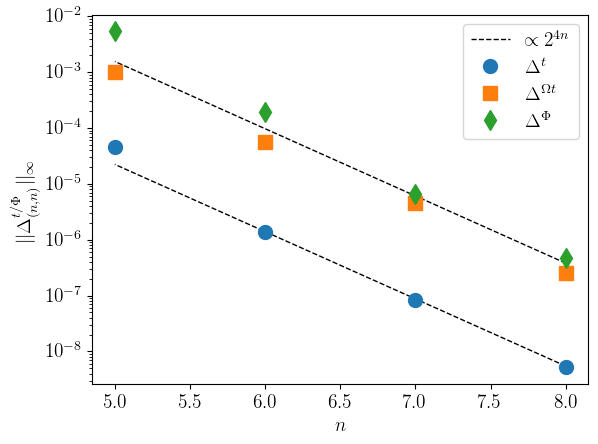

In [565]:
plt.plot([8, 7, 6, 5], 0.5*(np.max((phase_spline_error_3)) + np.max((time_spline_error_3)))*2.**(4*(4 - np.array([6, 5, 4, 3]))), 'k--', label = "$\propto 2^{4n}$", linewidth=1)
plt.plot([8, 7, 6, 5], (np.max((time_spline_error_3)))*2.**(4*(4 - np.array([6, 5, 4, 3]))), 'k--', linewidth=1)
plt.plot([8, 7, 6, 5], [np.max((time_spline_error)), np.max((time_spline_error_2)), np.max((time_spline_error_3)), np.max((time_spline_error_4))], 'o', label = "$\Delta^t$", markersize=10)
plt.plot([8, 7, 6, 5], [np.max((weighted_time_spline_error)), np.max((weighted_time_spline_error_2)), np.max((weighted_time_spline_error_3)), np.max((weighted_time_spline_error_4))], 's', label = "$\Delta^{\Omega t}$", markersize=10)
plt.plot([8, 7, 6, 5], [np.max((phase_spline_error)), np.max((phase_spline_error_2)), np.max((phase_spline_error_3)), np.max((phase_spline_error_4))], 'd', label = "$\Delta^\Phi$", markersize=10)
print(np.max((time_spline_error))/16, np.max((weighted_time_spline_error))/16, np.max((phase_spline_error))/16)
plt.legend()
plt.yscale('log')
plt.ylabel('$||\Delta^{X}_{(n, n)}||_\infty$')
plt.xlabel('$n$')
plt.savefig("../figures/timeAndPhaseConvergence.pdf", bbox_inches='tight')

In [432]:
# phase_difference = np.abs(phase_values - phase_values_downsample_1)
# phase_difference[phase_difference < 1.e-16] = 1.e-16
# print(np.max(phase_difference), np.max(phase_difference)/16)
# plt.pcolormesh(alpha_values, a_values, np.log10(phase_difference), shading='auto')
# plt.colorbar()
# plt.xlim(0,1)
# plt.ylim(-1,1)
# plt.show()

5.152052340307023e-09 3.2200327126918893e-10


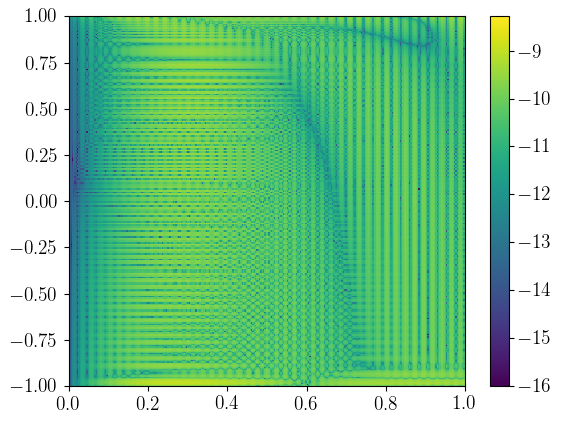

In [473]:
time_difference = np.abs((1 - (1-time_values)/(1- time_values_downsample_1)))
time_difference[time_difference < 1.e-16] = 1.e-16
print(np.max(time_difference), np.max(time_difference)/16)
plt.pcolormesh(alpha_values, a_values, np.log10(time_difference), shading='auto')
plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,1)
plt.show()

4.791005494553247e-07 2.994378434095779e-08


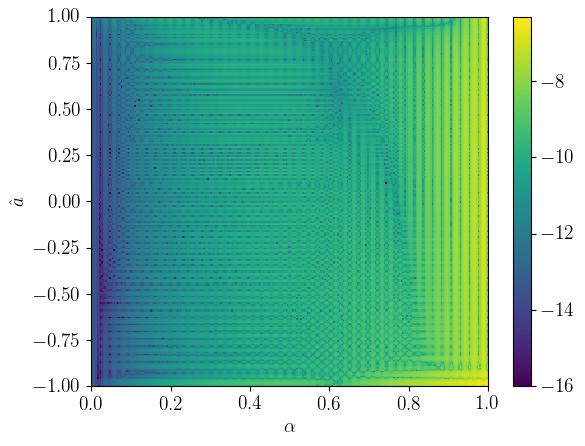

In [436]:
phase_difference = np.abs(phase_values - phase_values_downsample_1)
phase_difference[phase_difference < 1.e-16] = 1.e-16
print(np.max(phase_difference), np.max(phase_difference)/16)
plt.pcolormesh(alpha_values, a_values, np.log10(phase_difference), shading='auto')
plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,1)
plt.ylabel('$\hat{a}$')
plt.xlabel('$\\alpha$')
plt.title('$$')
plt.show()

In [435]:
chi_test = np.linspace(0.0, 1, 200)
alpha_test = np.linspace(0.0, 1, 300)
delta_flux = np.zeros((chi_test.shape[0], alpha_test.shape[0]))
Delta_flux = np.zeros((chi_test.shape[0], alpha_test.shape[0]))
delta_flux_2 = np.zeros((chi_test.shape[0], alpha_test.shape[0]))
Delta_flux_2 = np.zeros((chi_test.shape[0], alpha_test.shape[0]))
for i, chi in enumerate(chi_test):
    for j, alpha in enumerate(alpha_test):
        spin = spin_of_chi(chi)
        omega = omega_of_a_alpha(spin, alpha)
        rel_error = 1. - (1+(energy_omega_alpha_derivative(spin, omega))/flux_of_a_omega(spin, omega))/(1-time_of_a_omega(spin, omega, deriv = 1))
        rel_error_2 = 1. - (1 + omega*(energy_omega_alpha_derivative(spin, omega))/flux_of_a_omega(spin, omega))/(1 - phase_of_a_omega(spin, omega, deriv = 1))
        delta_flux[i, j] = np.abs(rel_error)
        Delta_flux[i, j] = np.abs(rel_error_2)
        # abs_error = (energy_omega_alpha_derivative(spin, omega))/flux_of_a_omega(spin, omega) - time2_of_a_omega(spin, omega, deriv = 1)
        # rel_error = 1. - (1+(energy_omega_alpha_derivative(spin, omega))/flux_of_a_omega(spin, omega))/(1+time2_of_a_omega(spin, omega, deriv = 1))
        # delta_flux_2[i, j] = np.abs(rel_error)
        # Delta_flux_2[i, j] = np.min([np.abs(abs_error), np.abs(rel_error)])

-6.690976526448588


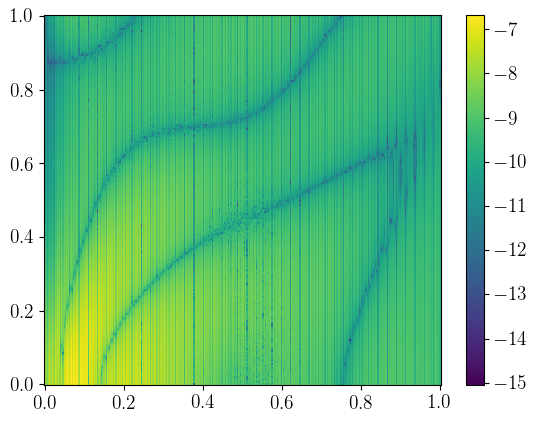

In [437]:
delta_flux[delta_flux<1.e-16] = 1.e-16
print(np.max(np.log10(delta_flux)))
plt.pcolormesh(alpha_test, chi_test, np.log10(delta_flux))
plt.colorbar()
plt.show()

-6.840677667164515


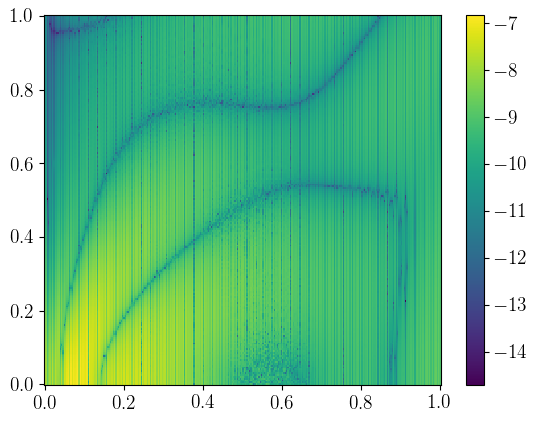

In [438]:
Delta_flux[Delta_flux<1.e-16] = 1.e-16
print(np.max(np.log10(Delta_flux)))
plt.pcolormesh(alpha_test, chi_test, np.log10(Delta_flux))
plt.colorbar()
plt.show()

## Calculate frequency differences

In [490]:
a_values = A_MAX*np.cos(np.linspace(0, np.pi, 300))
chi_values = chi_of_spin(a_values)
beta_values = np.linspace(0, 1, 300)

In [491]:
omega_beta_values = np.array([[omega_test(a, time_of_beta(a, beta), spl_num = 0) for beta in beta_values] for a in a_values])
omega_beta_values_values_downsample_1 = np.array([[omega_test(a, time_of_beta(a, beta), spl_num = 1) for beta in beta_values] for a in a_values])
omega_beta_values_values_downsample_2 = np.array([[omega_test(a, time_of_beta(a, beta), spl_num = 2) for beta in beta_values] for a in a_values])
omega_beta_values_values_downsample_3 = np.array([[omega_test(a, time_of_beta(a, beta), spl_num = 3) for beta in beta_values] for a in a_values])
omega_beta_values_values_downsample_4 = np.array([[omega_test(a, time_of_beta(a, beta), spl_num = 4) for beta in beta_values] for a in a_values])

In [492]:
omega_spline_error = np.abs(1. - omega_beta_values_values_downsample_1/omega_beta_values)
omega_spline_error[omega_spline_error<1.e-16] = 1.e-16
omega_spline_error_2 = np.abs(1 - omega_beta_values_values_downsample_2/omega_beta_values_values_downsample_1)
omega_spline_error_2[omega_spline_error_2<1.e-16] = 1.e-16
omega_spline_error_3 = np.abs(1 - omega_beta_values_values_downsample_3/omega_beta_values_values_downsample_2)
omega_spline_error_3[omega_spline_error_3<1.e-16] = 1.e-16
omega_spline_error_4 = np.abs(1 - omega_beta_values_values_downsample_4/omega_beta_values_values_downsample_3)
omega_spline_error_4[omega_spline_error_4<1.e-16] = 1.e-16

2.1953657780571234e-08 1.3721036112857021e-09


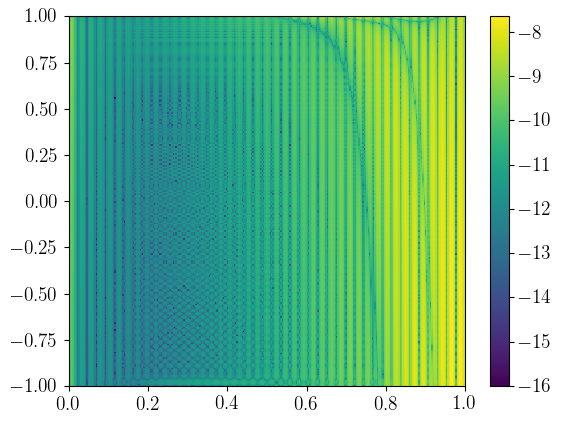

In [493]:
plt.pcolormesh(alpha_values, a_values, np.log10(omega_spline_error), shading='auto')
print(np.max(omega_spline_error), np.max(omega_spline_error)/16)
plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,1)
plt.show()

In [75]:
def phase_change_Tobs(Tobs, M, epsilon, a, omega_i, spl_num = 0):
    Phi_i = phase_of_a_omega(a, omega_i, spl_num = 0)
    t_i = time_of_a_omega(a, omega_i, spl_num = 0)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    if t_f > 0:
        t_f = 0
    omega_f = omega_test(a, t_f, spl_num = spl_num)
    Phi_f = phase_of_a_omega(a, omega_f, spl_num = 0)
    print(t_i, t_f, omega_f, Phi_f, Phi_i)
    return (Phi_f - Phi_i)/epsilon

def phase_error_Tobs(Tobs, M, epsilon, a, omega_i):
    return phase_change_Tobs(Tobs, M, epsilon, a, omega_i) - phase_change_Tobs(Tobs, M, epsilon, a, omega_i, spl_num = 1)

1.3721036112857021e-09


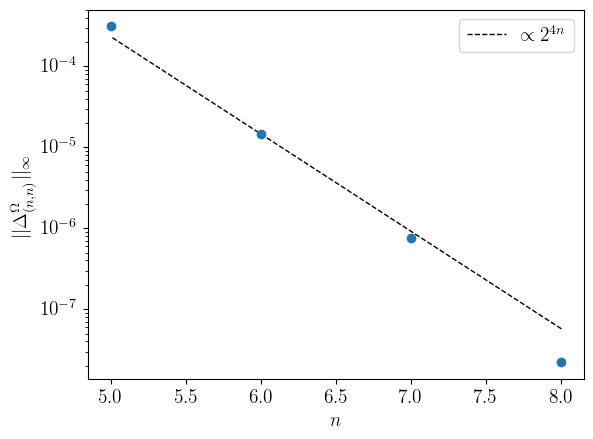

In [561]:
plt.plot([8, 7, 6, 5], (np.max((omega_spline_error_3)))*2.**(4*(4 - np.array([6, 5, 4, 3]))), 'k--', label = "$\propto 2^{4n}$", linewidth=1)
plt.plot([8, 7, 6, 5], [np.max((omega_spline_error)), np.max((omega_spline_error_2)), np.max((omega_spline_error_3)), np.max((omega_spline_error_4))], 'o')
plt.legend()
plt.yscale('log')
plt.ylabel('$||\Delta^{\Omega}_{(n, n)}||_\infty$')
plt.xlabel('$n$')
print(np.max((omega_spline_error))/16)
plt.savefig("../figures/frequencyConvergence.pdf", bbox_inches='tight')

In [499]:
omega_func = omega_test
time_spline_test_array = np.array([[time_of_a_omega(a, omega_func(a, time_of_beta(a, beta))) for beta in beta_values] for a in a_values])
time_test_array = np.array([[time_of_beta(a, beta) for beta in beta_values] for a in a_values])
omega_spline_test_array = np.array([[omega_func(a, time_of_a_omega(a, omega_of_a_alpha(a, alpha))) for alpha in alpha_values] for a in a_values])
omega_test_array = np.array([[omega_of_a_alpha(a, alpha) for alpha in alpha_values] for a in a_values])

In [500]:
phase_omega_spline_test_array = np.array([[phase_difference_frequency(a, omega_func(a, time_of_a_omega(a, omega_of_a_alpha(a, alpha)))) for alpha in alpha_values] for a in a_values])
phase_omega_test_array = np.array([[phase_difference_frequency(a, omega_of_a_alpha(a, alpha)) for alpha in alpha_values] for a in a_values])

1.05736652766808e-09


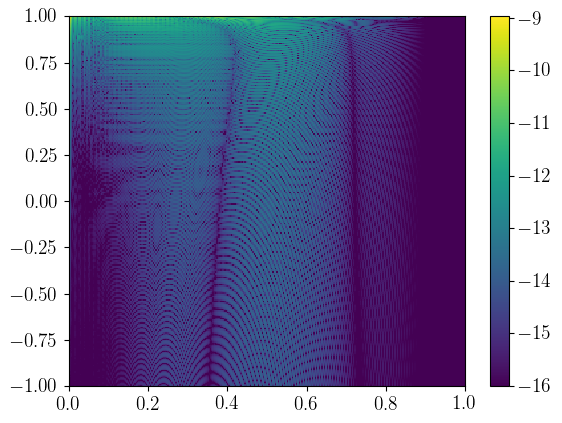

In [501]:
delta_phase_spline_error = np.abs(phase_omega_spline_test_array - phase_omega_test_array)
delta_phase_spline_error[delta_phase_spline_error<1.e-16] = 1.e-16
print(np.max(delta_phase_spline_error))
plt.pcolormesh(alpha_values, a_values, np.log10(delta_phase_spline_error))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,1)
plt.show()

3.314984731161985e-09


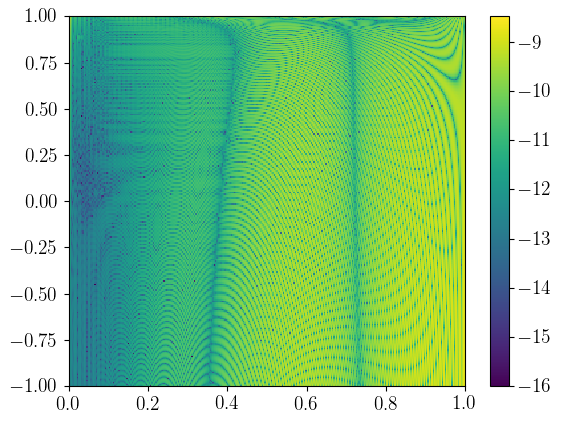

In [504]:
delta_omega_spline_error = np.abs(1-omega_spline_test_array/omega_test_array)
delta_omega_spline_error[delta_omega_spline_error<1.e-16] = 1.e-16
print(np.max(delta_omega_spline_error))
plt.pcolormesh(alpha_values, a_values, np.log10(delta_omega_spline_error))
plt.colorbar()
plt.xlim(0,1)
plt.ylim(-1,1)
plt.show()

In [126]:
from scipy.optimize import root_scalar

def root_find_time(omega, t0, a):
    return time_of_a_omega(a, omega) - t0

def root_find_beta(alpha, beta, chi):
    a = spin_of_chi(chi)
    omega = omega_of_a_alpha(a, alpha)
    return beta_of_time(a, time_spl[0](chi, alpha)*pn_time_noprefactor(a, omega)) - beta

def omega_of_a_time_root(a, t0):
    omega_max = kerr_isco_frequency(a)
    sol = root_scalar(root_find_time, args=(t0, a), method='brentq', bracket=[OMEGA_MIN, omega_max], rtol = 1.e-12)
    return sol.root

def alpha_of_chi_beta_root(chi, beta):
    sol = root_scalar(root_find_beta, args=(beta, chi), method='brentq', bracket=[0, 1], rtol = 1.e-12)
    return sol.root

## Amplitudes

In [513]:
ampDataLM = {}
magLM = {}
phaseLM = {}
magLMSpline = {}
phaseLMSpline = {}
magLMSpline_downsample = {}
phaseLMSpline_downsample = {}
magLMSpline_downsample_2 = {}
phaseLMSpline_downsample_2 = {}
magLMSpline_downsample_3 = {}
phaseLMSpline_downsample_3 = {}
lmax = 20

alphaDataAmp = np.linspace(0, 1, 65)
chiDataAmp = np.linspace(0, 1, 65)
for m in range(1, lmax + 1):
    lmin = np.max([m, 2])
    for l in range(lmin, lmax + 1):
        ampDataLM[(l,m)] = np.loadtxt(f"/Users/zachnasipak/Documents/Research/Projects/CircularOrbits/data/circ_data_{l}_{m}.txt", skiprows=3)
        magLM[(l, m)] = ampDataLM[(l,m)][:, 2].reshape(65,65)
        phaseLM[(l, m)] = ampDataLM[(l,m)][:, 3].reshape(65,65)
        magLMSpline[(l, m)] = BicubicSpline(chiDataAmp, alphaDataAmp, np.log(magLM[(l, m)]), bc = 'E(3)')
        phaseLMSpline[(l, m)] = BicubicSpline(chiDataAmp, alphaDataAmp, phaseLM[(l, m)], bc = 'E(3)')
        magLMSpline_downsample[(l, m)] = BicubicSpline(chiDataAmp[::2], alphaDataAmp[::2], np.log(magLM[(l, m)])[::2, ::2], bc = 'E(3)')
        phaseLMSpline_downsample[(l, m)] = BicubicSpline(chiDataAmp[::2], alphaDataAmp[::2], phaseLM[(l, m)][::2, ::2], bc = 'E(3)')
        magLMSpline_downsample_2[(l, m)] = BicubicSpline(chiDataAmp[::4], alphaDataAmp[::4], np.log(magLM[(l, m)])[::4, ::4], bc = 'E(3)')
        phaseLMSpline_downsample_2[(l, m)] = BicubicSpline(chiDataAmp[::4], alphaDataAmp[::4], phaseLM[(l, m)][::4, ::4], bc = 'E(3)')
        magLMSpline_downsample_3[(l, m)] = BicubicSpline(chiDataAmp[::8], alphaDataAmp[::8], np.log(magLM[(l, m)])[::8, ::8], bc = 'E(3)')
        phaseLMSpline_downsample_3[(l, m)] = BicubicSpline(chiDataAmp[::8], alphaDataAmp[::8], phaseLM[(l, m)][::8, ::8], bc = 'E(3)')

In [514]:
spin_amp_samples = A_MAX*np.cos(np.linspace(0, np.pi, 100))
chi_amp_samples = chi_of_spin(spin_amp_samples)
alpha_amp_samples = np.linspace(0, 1, 100)
chi_amp_samples = chi_of_spin(spin_amp_samples)
ALPHA_AMP, CHI_AMP = np.meshgrid(alpha_amp_samples, chi_amp_samples)
SPIN_AMP = spin_of_chi(CHI_AMP)
OMEGA_AMP = omega_of_a_alpha(SPIN_AMP, ALPHA_AMP)
RADIUS_AMP = kerr_circ_geo_radius(SPIN_AMP, OMEGA_AMP)

In [515]:
lmtuple = (2,2)
Alm_sample = np.array([[np.exp(magLMSpline[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
Alm_downsample = np.array([[np.exp(magLMSpline_downsample[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
Alm_downsample_2 = np.array([[np.exp(magLMSpline_downsample_2[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
Alm_downsample_3 = np.array([[np.exp(magLMSpline_downsample_3[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
Alm_compare = np.abs(1-Alm_sample/Alm_downsample)
Alm_compare[Alm_compare == 0.] = 1.e-16
Alm_compare_2 = np.abs(1-Alm_downsample/Alm_downsample_2)
Alm_compare_2[Alm_compare_2 == 0.] = 1.e-16
Alm_compare_3 = np.abs(1-Alm_downsample_2/Alm_downsample_3)
Alm_compare_3[Alm_compare_3 == 0.] = 1.e-16
print(np.max(np.log10(Alm_compare)), np.max(np.log10(Alm_compare_2)), np.max(np.log10(Alm_compare_3)))
print(np.max(Alm_compare_2)/np.max(Alm_compare), np.max((Alm_compare_3))/np.max((Alm_compare_2)))

-3.2246128810269226 -2.2614953883464533 -1.5056568893276732
9.185810729419389 5.699522848525937


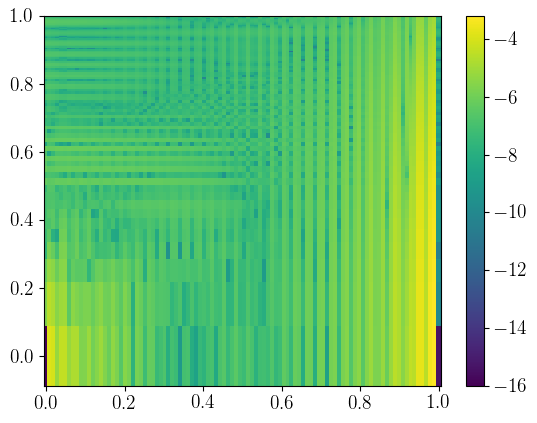

In [516]:
plt.pcolor(alpha_amp_samples, chi_amp_samples, np.log10(Alm_compare))
plt.colorbar()
plt.show()

In [519]:
lmtuple = (2,2)
psilm_sample = np.array([[(phaseLMSpline[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
psilm_downsample = np.array([[(phaseLMSpline_downsample[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
psilm_downsample_2 = np.array([[(phaseLMSpline_downsample_2[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
psilm_downsample_3 = np.array([[(phaseLMSpline_downsample_3[lmtuple](chi, alpha)) for alpha in alpha_amp_samples] for chi in chi_amp_samples])
psilm_compare = np.abs(psilm_sample-psilm_downsample)
psilm_compare[psilm_compare == 0.] = 1.e-16
psilm_compare_2 = np.abs(psilm_downsample-psilm_downsample_2)
psilm_compare_2[psilm_compare_2 == 0.] = 1.e-16
psilm_compare_3 = np.abs(psilm_downsample_2-psilm_downsample_3)
psilm_compare_3[psilm_compare_3 == 0.] = 1.e-16
print(np.max(np.log10(psilm_compare)), np.max(np.log10(psilm_compare_2)), np.max(np.log10(psilm_compare_3)))
print(np.max(psilm_compare_2)/np.max(psilm_compare), np.max((psilm_compare_3))/np.max((psilm_compare_2)))

-3.2105589508753862 -2.242199500229918 -1.3605211118349552
9.297355786657562 7.6151487040202985


In [520]:
np.max(psilm_compare), np.max(psilm_compare_2)

(0.0006158019348525556, 0.005725329682436331)

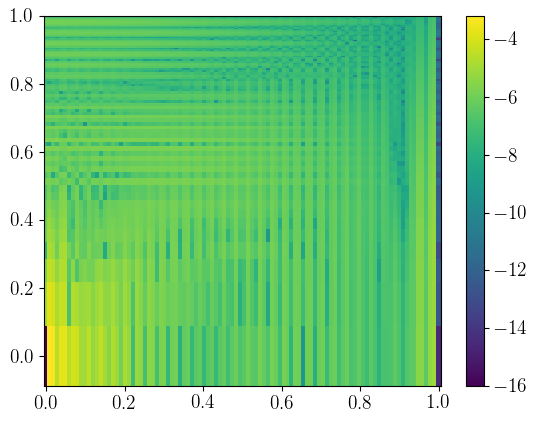

In [521]:
plt.pcolor(alpha_amp_samples, chi_amp_samples, np.log10(psilm_compare))
plt.colorbar()
plt.show()

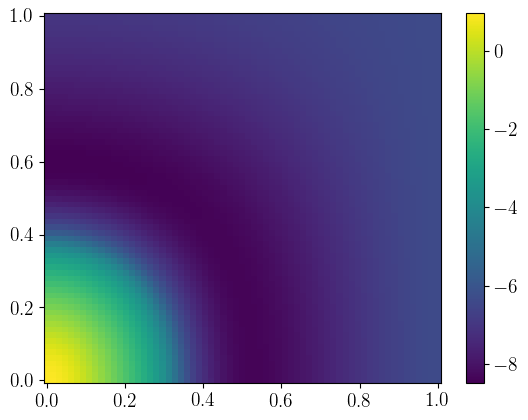

In [522]:
plt.pcolor(alphaDataAmp, chiDataAmp, phaseLM[(20,2)])
plt.colorbar()
plt.show()

In [523]:
# spin = A_MAX*np.cos(np.linspace(0, np.pi, 10))
# chiTemp = chi_of_spin(spin)
chiTemp = np.linspace(0, 1, 10)
alphaTemp = np.linspace(0, 1, 30)
chiA, alphaA = np.meshgrid(chiTemp, alphaTemp)
spinVals = spin_of_chi(chiA)
omegaVals = omega_of_a_alpha(spinVals, alphaA)
radialVals = kerr_circ_geo_radius(spinVals, omegaVals)
output_22=np.array([[0.60076142, 0.61558213, 0.65789244, 0.72239779, 0.80283603,
        0.89335423, 0.98886456, 1.08494872, 1.17767264, 1.26340721,
        1.33868751, 1.40016267, 1.44468878, 1.46957282, 1.47290611,
        1.45386917, 1.41288531, 1.35155678, 1.2724071 , 1.17852257,
        1.07320267, 0.95969825, 0.84106772, 0.72014284, 0.59957734,
        0.48194984, 0.36989823, 0.2662684 , 0.17425921, 0.09753378],
       [0.69421524, 0.70680152, 0.74311163, 0.79937286, 0.8706939 ,
        0.95205007, 1.03874551, 1.12651329, 1.21145394, 1.2899218 ,
        1.35842833, 1.41362701, 1.45242695, 1.47223507, 1.47126426,
        1.44879914, 1.40531338, 1.34238764, 1.26245676, 1.16847306,
        1.06358415, 0.95089388, 0.83333224, 0.71362577, 0.59434455,
        0.47799977, 0.36717127, 0.26464919, 0.17357224, 0.09753381],
       [0.92332311, 0.9319087 , 0.95698989, 0.99666364, 1.04811785,
        1.10801301, 1.17279732, 1.23889769, 1.3028011 , 1.36107737,
        1.41040458, 1.44764941, 1.4700281 , 1.47533258, 1.46216517,
        1.43010457, 1.37974052, 1.31256019, 1.23072177, 1.1367835 ,
        1.03345614, 0.92342419, 0.80925105, 0.69336103, 0.57808098,
        0.46572291, 0.35869243, 0.25961009, 0.17143058, 0.09753403],
       [1.20657448, 1.21139197, 1.22553067, 1.24806478, 1.27750778,
        1.3119014 , 1.34892792, 1.38602458, 1.42048962, 1.44958665,
        1.4706628 , 1.48129255, 1.47944323, 1.46363976, 1.43309255,
        1.38775424, 1.32828754, 1.25595255, 1.1724437 , 1.07971605,
        0.97983544, 0.87487388, 0.76685654, 0.65775635, 0.54952701,
        0.44416459, 0.3437887 , 0.25073457, 0.16764409, 0.09753512],
       [1.46220828, 1.46369182, 1.46799896, 1.47469471, 1.483046  ,
        1.49202749, 1.5003519 , 1.50652832, 1.50894492, 1.50597   ,
        1.49606352, 1.47788961, 1.45041813, 1.41300179, 1.36541728,
        1.30786474, 1.24092813, 1.16550671, 1.08273287, 0.99389182,
        0.90035553, 0.80353838, 0.704877  , 0.60583348, 0.50791891,
        0.41273374, 0.32202083, 0.23772623, 0.16205955, 0.09753912],
       [1.58769184, 1.58653327, 1.58301971, 1.57703328, 1.56836603,
        1.55671213, 1.54167038, 1.52276202, 1.49946372, 1.47125181,
        1.4376511 , 1.39828157, 1.35289688, 1.30141044, 1.24390714,
        1.18064115, 1.11202228, 1.03859494, 0.96101408, 0.88002265,
        0.79643384, 0.71112069, 0.62501435, 0.53911134, 0.45448977,
        0.37233359, 0.29396351, 0.22087203, 0.15475782, 0.09755092],
       [1.51071595, 1.50826301, 1.50092806, 1.488779  , 1.47191744,
        1.4504651 , 1.42455056, 1.39429952, 1.35983075, 1.32125759,
        1.27869414, 1.23226414, 1.18211071, 1.12840525, 1.07135452,
        1.0112055 , 0.94824814, 0.88281659, 0.81528964, 0.74609125,
        0.67569212, 0.60461295, 0.53343014, 0.46278424, 0.39339151,
        0.32605839, 0.26169859, 0.20135145, 0.1461994 , 0.09758066],
       [1.27657472, 1.27411333, 1.26676429, 1.2546304 , 1.23787475,
        1.21670979, 1.19138435, 1.16217042, 1.12935123, 1.09321155,
        1.05403092, 1.0120798 , 0.96761823, 0.92089675, 0.8721588 ,
        0.82164428, 0.76959373, 0.71625312, 0.66187878, 0.60674277,
        0.55113853, 0.49538704, 0.43984352, 0.38490492, 0.33101809,
        0.27868874, 0.22849098, 0.18107686, 0.13718518, 0.09764808],
       [0.99248374, 0.99055874, 0.98480954, 0.97531217, 0.96218922,
        0.94560396, 0.9257531 , 0.9028586 , 0.8771595 , 0.84890412,
        0.81834334, 0.78572518, 0.75129077, 0.71527197, 0.67789029,
        0.63935721, 0.59987549, 0.55964145, 0.51884803, 0.47768837,
        0.43635995, 0.39506907, 0.3540357 , 0.3134986 , 0.27372066,
        0.23499434, 0.19764723, 0.16204734, 0.12860807, 0.09779211],
       [0.73253132, 0.73119469, 0.72720037, 0.7205944 , 0.71145174,
        0.69987367, 0.68598436, 0.66992704, 0.6518597 , 0.63195081,
        0.61037523, 0.58731041, 0.56293319, 0.53741717, 0.51093081,
        0.4836362 , 0.45568858, 0.42723646, 0.39842234, 0.36938406,
        0.34025648, 0.31117366, 0.28227133, 0.25368962, 0.22557602,
        0.19808843, 0.17139827, 0.14569358, 0.12118195, 0.09809316]])

In [524]:
output_52 = np.array([[1.51738326e-03, 1.53676077e-03, 1.58349021e-03, 1.63042462e-03,
        1.64981076e-03, 1.62511897e-03, 1.55419418e-03, 1.44668678e-03,
        1.32045978e-03, 1.19783114e-03, 1.09919288e-03, 1.03356033e-03,
        9.92893750e-04, 9.57831078e-04, 9.09934041e-04, 8.39669446e-04,
        7.47235166e-04, 6.39374794e-04, 5.25402832e-04, 4.14156075e-04,
        3.12392167e-04, 2.24408913e-04, 1.52335098e-04, 9.65911112e-05,
        5.62668892e-05, 2.94086291e-05, 1.33186033e-05, 4.94880315e-06,
        1.37421126e-06, 2.37671933e-07],
       [1.61527847e-03, 1.62336300e-03, 1.64065369e-03, 1.65048027e-03,
        1.63567007e-03, 1.58617521e-03, 1.50185043e-03, 1.39169685e-03,
        1.27172412e-03, 1.16130068e-03, 1.07640732e-03, 1.02121588e-03,
        9.85095377e-04, 9.49587015e-04, 8.98963771e-04, 8.26090099e-04,
        7.32409881e-04, 6.24888419e-04, 5.12475903e-04, 4.03460393e-04,
        3.04112705e-04, 2.18397894e-04, 1.48260158e-04, 9.40421209e-05,
        5.48255250e-05, 2.86954310e-05, 1.30258375e-05, 4.85852390e-06,
        1.35789203e-06, 2.37672140e-07],
       [1.60839055e-03, 1.60210522e-03, 1.58199123e-03, 1.54515340e-03,
        1.48918088e-03, 1.41440576e-03, 1.32539844e-03, 1.23119247e-03,
        1.14366348e-03, 1.07348509e-03, 1.02464966e-03, 9.91399707e-04,
        9.60977975e-04, 9.20196865e-04, 8.60792411e-04, 7.81158143e-04,
        6.85194114e-04, 5.79892694e-04, 4.72942085e-04, 3.71049088e-04,
        2.79152563e-04, 2.00326484e-04, 1.36026035e-04, 8.63926776e-05,
        5.04981841e-05, 2.65509173e-05, 1.21426874e-05, 4.58458279e-06,
        1.30784819e-06, 2.37673671e-07],
       [1.27322979e-03, 1.26632147e-03, 1.24616764e-03, 1.21451873e-03,
        1.17438641e-03, 1.13002382e-03, 1.08648778e-03, 1.04846279e-03,
        1.01845492e-03, 9.95234734e-04, 9.73738406e-04, 9.46795327e-04,
        9.07736452e-04, 8.52527394e-04, 7.80676401e-04, 6.94930809e-04,
        6.00198336e-04, 5.02226944e-04, 4.06475797e-04, 3.17406659e-04,
        2.38209094e-04, 1.70825115e-04, 1.16100208e-04, 7.39407145e-05,
        4.34452279e-05, 2.30429503e-05, 1.06876170e-05, 4.12739631e-06,
        1.22241058e-06, 2.37681167e-07],
       [9.98125133e-04, 9.97491960e-04, 9.95683210e-04, 9.92902790e-04,
        9.89277538e-04, 9.84592379e-04, 9.78034126e-04, 9.68055955e-04,
        9.52466046e-04, 9.28775679e-04, 8.94735333e-04, 8.48900422e-04,
        7.91049511e-04, 7.22331975e-04, 6.45117394e-04, 5.62613150e-04,
        4.78375766e-04, 3.95849350e-04, 3.18025775e-04, 2.47258489e-04,
        1.85204693e-04, 1.32841669e-04, 9.05079148e-05, 5.79467962e-05,
        3.43599248e-05, 1.84934010e-05, 8.77656103e-06, 3.51368939e-06,
        1.10332920e-06, 2.37708800e-07],
       [9.47199199e-04, 9.45557376e-04, 9.40504309e-04, 9.31672680e-04,
        9.18500819e-04, 9.00305328e-04, 8.76376858e-04, 8.46092704e-04,
        8.09035650e-04, 7.65103396e-04, 7.14589509e-04, 6.58218306e-04,
        5.97123484e-04, 5.32772165e-04, 4.66848337e-04, 4.01117923e-04,
        3.37298873e-04, 2.76953697e-04, 2.21411674e-04, 1.71718143e-04,
        1.28602836e-04, 9.24597246e-05, 6.33360773e-05, 4.09349754e-05,
        2.46398625e-05, 1.35694971e-05, 6.66643341e-06, 2.81315637e-06,
        9.59665599e-07, 2.37790411e-07],
       [7.12196319e-04, 7.09495762e-04, 7.01421672e-04, 6.88058528e-04,
        6.69552691e-04, 6.46119913e-04, 6.18054132e-04, 5.85735840e-04,
        5.49637975e-04, 5.10327288e-04, 4.68459611e-04, 4.24768243e-04,
        3.80045724e-04, 3.35120163e-04, 2.90827846e-04, 2.47983927e-04,
        2.07352690e-04, 1.69618421e-04, 1.35357592e-04, 1.05013184e-04,
        7.88724612e-05, 5.70503288e-05, 3.94811062e-05, 2.59218666e-05,
        1.59699897e-05, 9.09615830e-06, 4.69169261e-06, 2.12613284e-06,
        8.07857886e-07, 2.37996251e-07],
       [4.12928805e-04, 4.11099154e-04, 4.05649483e-04, 3.96696236e-04,
        3.84428936e-04, 3.69103847e-04, 3.51035954e-04, 3.30589864e-04,
        3.08170142e-04, 2.84211442e-04, 2.59168585e-04, 2.33506588e-04,
        2.07690545e-04, 1.82175230e-04, 1.57394338e-04, 1.33749408e-04,
        1.11598603e-04, 9.12457216e-05, 7.29300026e-05, 5.68174392e-05,
        4.29944645e-05, 3.14649007e-05, 2.21510222e-05, 1.48993951e-05,
        9.49182599e-06, 5.66126337e-06, 3.11187297e-06, 1.54178169e-06,
        6.66255242e-07, 2.38464396e-07],
       [2.04863674e-04, 2.03896277e-04, 2.01017968e-04, 1.96299432e-04,
        1.89855371e-04, 1.81840066e-04, 1.72441603e-04, 1.61875108e-04,
        1.50375381e-04, 1.38189282e-04, 1.25568189e-04, 1.12760778e-04,
        1.00006312e-04, 8.75285813e-05, 7.55305653e-05, 6.41899003e-05,
        5.36551817e-05, 4.40431620e-05, 3.54368940e-05, 2.78848858e-05,
        2.14013343e-05, 1.59675036e-05, 1.15342955e-05, 8.02602333e-06,
        5.34534647e-06, 3.37923902e-06, 2.00576739e-06, 1.10132752e-06,
        5.47863813e-07, 2.39470350e-07],
       [8.91458465e-05, 8.87166314e-05, 8.74404123e-05, 8.53509642e-05,
        8.25029369e-05, 7.89695077e-05, 7.48393178e-05, 7.02128851e-05,
        6.51987093e-05, 5.99092859e-05, 5.44572321e-05, 4.89516985e-05,
        4.34952022e-05, 3.81809770e-05, 3.30908938e-05, 2.82939680e-05,
        2.38454399e-05, 1.97863897e-05, 1.61438366e-05, 1.29312605e-05,
        1.01494851e-05, 7.78786354e-06, 5.82571195e-06, 4.23394242e-06,
        2.97685105e-06, 2.01401748e-06, 1.30226994e-06, 7.97661735e-07,
        4.57392807e-07, 2.41593723e-07]])

In [525]:
output_55 = np.array([[1.64001039e-01, 1.67256426e-01, 1.76289913e-01, 1.89223788e-01,
        2.03733876e-01, 2.17648046e-01, 2.29240453e-01, 2.37300135e-01,
        2.41096811e-01, 2.40314456e-01, 2.34980300e-01, 2.25396863e-01,
        2.12077934e-01, 1.95688271e-01, 1.76987325e-01, 1.56777781e-01,
        1.35859830e-01, 1.14991926e-01, 9.48584985e-02, 7.60447744e-02,
        5.90185796e-02, 4.41187372e-02, 3.15495003e-02, 2.13804224e-02,
        1.35512525e-02, 7.88192752e-03, 4.08856672e-03, 1.80742868e-03,
        6.29573712e-04, 1.48226039e-04],
       [1.84788348e-01, 1.87220891e-01, 1.94020643e-01, 2.03857762e-01,
        2.14972494e-01, 2.25598536e-01, 2.34241506e-01, 2.39796515e-01,
        2.41563462e-01, 2.39213972e-01, 2.32739831e-01, 2.22395825e-01,
        2.08641901e-01, 1.92086752e-01, 1.73434285e-01, 1.53434222e-01,
        1.32837954e-01, 1.12360460e-01, 9.26488054e-02, 7.42573958e-02,
        5.76299156e-02, 4.30875912e-02, 3.08232797e-02, 2.09008358e-02,
        1.32593944e-02, 7.72267163e-03, 4.01417835e-03, 1.78023663e-03,
        6.23412345e-04, 1.48226151e-04],
       [2.25872855e-01, 2.26836767e-01, 2.29527072e-01, 2.33373069e-01,
        2.37538016e-01, 2.41073786e-01, 2.43077530e-01, 2.42807907e-01,
        2.39748861e-01, 2.33629793e-01, 2.24416235e-01, 2.12282696e-01,
        1.97575695e-01, 1.80772242e-01, 1.62437300e-01, 1.43182721e-01,
        1.23629392e-01, 1.04373787e-01, 8.59596726e-02, 6.88553630e-02,
        5.34365839e-02, 3.99747866e-02, 2.86305706e-02, 1.94518494e-02,
        1.23765469e-02, 7.24001749e-03, 3.78805470e-03, 1.69717782e-03,
        6.04435607e-04, 1.48226980e-04],
       [2.53159409e-01, 2.52990196e-01, 2.52432691e-01, 2.51337734e-01,
        2.49465313e-01, 2.46511970e-01, 2.42156697e-01, 2.36113220e-01,
        2.28175038e-01, 2.18245282e-01, 2.06349682e-01, 1.92634792e-01,
        1.77355032e-01, 1.60852244e-01, 1.43530944e-01, 1.25831895e-01,
        1.08205959e-01, 9.10897231e-02, 7.48839033e-02, 5.99351918e-02,
        4.65218826e-02, 3.48433805e-02, 2.50135453e-02, 1.70577775e-02,
        1.09138707e-02, 6.43695260e-03, 3.40932570e-03, 1.55658938e-03,
        5.71736681e-04, 1.48231039e-04],
       [2.46131547e-01, 2.45390035e-01, 2.43174493e-01, 2.39507844e-01,
        2.34417946e-01, 2.27930467e-01, 2.20068897e-01, 2.10862382e-01,
        2.00358243e-01, 1.88634751e-01, 1.75810651e-01, 1.62049534e-01,
        1.47558715e-01, 1.32583233e-01, 1.17396133e-01, 1.02286296e-01,
        8.75450497e-02, 7.34526166e-02, 6.02652493e-02, 4.82037002e-02,
        3.74434695e-02, 2.81071238e-02, 2.02588723e-02, 1.39015642e-02,
        8.97633745e-03, 5.36534109e-03, 2.89823423e-03, 1.36347111e-03,
        5.25476056e-04, 1.48245999e-04],
       [2.03688297e-01, 2.02858847e-01, 2.00393310e-01, 1.96357142e-01,
        1.90850602e-01, 1.83998667e-01, 1.75941653e-01, 1.66828505e-01,
        1.56813347e-01, 1.46054661e-01, 1.34715898e-01, 1.22966266e-01,
        1.10980772e-01, 9.89390039e-02, 8.70225249e-02, 7.54110184e-02,
        6.42774922e-02, 5.37829156e-02, 4.40706711e-02, 3.52611717e-02,
        2.74469477e-02, 2.06884636e-02, 1.50108998e-02, 1.04021389e-02,
        6.81225044e-03, 4.15486068e-03, 2.31092919e-03, 1.13556192e-03,
        4.68468024e-04, 1.48290166e-04],
       [1.42754213e-01, 1.42111781e-01, 1.40203283e-01, 1.37083531e-01,
        1.32838931e-01, 1.27581096e-01, 1.21439638e-01, 1.14555212e-01,
        1.07073555e-01, 9.91409013e-02, 9.09007501e-02, 8.24917305e-02,
        7.40462147e-02, 6.56893160e-02, 5.75379866e-02, 4.97000264e-02,
        4.22729052e-02, 3.53423811e-02, 2.89809551e-02, 2.32462381e-02,
        1.81793332e-02, 1.38033562e-02, 1.01222330e-02, 7.11994253e-03,
        4.76040848e-03, 2.98828839e-03, 1.73095795e-03, 9.02011338e-04,
        4.06557021e-04, 1.48401450e-04],
       [8.55626404e-02, 8.51683061e-02, 8.39965279e-02, 8.20802579e-02,
        7.94721064e-02, 7.62411996e-02, 7.24693502e-02, 6.82469643e-02,
        6.36690696e-02, 5.88317568e-02, 5.38292096e-02, 4.87513870e-02,
        4.36823260e-02, 3.86989785e-02, 3.38704604e-02, 2.92575905e-02,
        2.49126092e-02, 2.08789889e-02, 1.71912760e-02, 1.38749319e-02,
        1.09461670e-02, 8.41178442e-03, 6.26907597e-03, 4.50583360e-03,
        3.10056362e-03, 2.02301133e-03, 1.23512117e-03, 6.92561853e-04,
        3.46926494e-04, 1.48653994e-04],
       [4.49097330e-02, 4.47061738e-02, 4.41009993e-02, 4.31104248e-02,
        4.17605253e-02, 4.00859071e-02, 3.81280257e-02, 3.59332957e-02,
        3.35511413e-02, 3.10321218e-02, 2.84262373e-02, 2.57814877e-02,
        2.31427203e-02, 2.05507718e-02, 1.80418832e-02, 1.56473518e-02,
        1.33933722e-02, 1.13010200e-02, 9.38633223e-03, 7.66044772e-03,
        6.12978043e-03, 4.79620881e-03, 3.65727761e-03, 2.70641948e-03,
        1.93321531e-03, 1.32372204e-03, 8.60904834e-04, 5.25213760e-04,
        2.95342641e-04, 1.49194509e-04],
       [2.12954076e-02, 2.12036776e-02, 2.09308003e-02, 2.04836077e-02,
        1.98731395e-02, 1.91141497e-02, 1.82244695e-02, 1.72242686e-02,
        1.61352673e-02, 1.49799445e-02, 1.37807873e-02, 1.25596165e-02,
        1.13370122e-02, 1.01318552e-02, 8.96098851e-03, 7.83899290e-03,
        6.77806776e-03, 5.78799991e-03, 4.87620346e-03, 4.04781232e-03,
        3.30580890e-03, 2.65117475e-03, 2.08305286e-03, 1.59891506e-03,
        1.19473239e-03, 8.65150283e-04, 6.03674061e-04, 4.02873111e-04,
        2.54613488e-04, 1.50328308e-04]])

In [526]:
output_2020 = np.array([[4.72047151e-03, 4.74772974e-03, 4.80709033e-03, 4.84061376e-03,
        4.78160088e-03, 4.58326522e-03, 4.23255449e-03, 3.74893614e-03,
        3.17502600e-03, 2.56447492e-03, 1.97033623e-03, 1.43591356e-03,
        9.89277309e-04, 6.41809617e-04, 3.90273035e-04, 2.21198770e-04,
        1.16071194e-04, 5.59273340e-05, 2.44943818e-05, 9.62739735e-06,
        3.34101961e-06, 1.00228249e-06, 2.52737717e-07, 5.15729190e-08,
        8.07754729e-09, 8.99910596e-10, 6.36164644e-11, 2.37958713e-12,
        3.44236500e-14, 1.04313801e-16],
       [4.96764214e-03, 4.96330330e-03, 4.93913729e-03, 4.86462216e-03,
        4.70188811e-03, 4.42338809e-03, 4.02391683e-03, 3.52237619e-03,
        2.95589542e-03, 2.37042062e-03, 1.81099873e-03, 1.31393035e-03,
        9.02063964e-04, 5.83627109e-04, 3.54152996e-04, 2.00422239e-04,
        1.05063582e-04, 5.05970316e-05, 2.21585755e-05, 8.71285851e-06,
        3.02635550e-06, 9.09196879e-07, 2.29746593e-07, 4.70194520e-08,
        7.39463366e-09, 8.28632046e-10, 5.90782055e-11, 2.23888032e-12,
        3.30915405e-14, 1.04314116e-16],
       [4.90274640e-03, 4.85626389e-03, 4.71839422e-03, 4.49245842e-03,
        4.18226373e-03, 3.79428398e-03, 3.34146317e-03, 2.84503986e-03,
        2.33294013e-03, 1.83556287e-03, 1.38068453e-03, 9.89112879e-04,
        6.72169457e-04, 4.31385873e-04, 2.60147576e-04, 1.46555271e-04,
        7.65960374e-05, 3.68310813e-05, 1.61283101e-05, 6.35033325e-06,
        2.21215542e-06, 6.67680680e-07, 1.69856914e-07, 3.50917687e-08,
        5.59180615e-09, 6.38380055e-10, 4.67678337e-11, 1.84758168e-12,
        2.92309952e-14, 1.04316447e-16],
       [3.73748969e-03, 3.68420828e-03, 3.52945686e-03, 3.28699789e-03,
        2.97589009e-03, 2.61740055e-03, 2.23319543e-03, 1.84436127e-03,
        1.47044749e-03, 1.12819088e-03, 8.30134465e-04, 5.83596924e-04,
        3.90377063e-04, 2.47326780e-04, 1.47646199e-04, 8.25551609e-05,
        4.29331367e-05, 2.05933632e-05, 9.01813605e-06, 3.56016314e-06,
        1.24697933e-06, 3.79648449e-07, 9.78053596e-08, 2.05658219e-08,
        3.35873450e-09, 3.97011246e-10, 3.05935563e-11, 1.30509683e-12,
        2.33842713e-14, 1.04327862e-16],
       [1.97199214e-03, 1.93902426e-03, 1.84365689e-03, 1.69569537e-03,
        1.50916587e-03, 1.29983843e-03, 1.08305715e-03, 8.72217586e-04,
        6.77880572e-04, 5.07374574e-04, 3.64758841e-04, 2.51078100e-04,
        1.64864276e-04, 1.02822985e-04, 6.06081712e-05, 3.35672474e-05,
        1.73480763e-05, 8.29768141e-06, 3.63649873e-06, 1.44234214e-06,
        5.09785491e-07, 1.57420622e-07, 4.13933889e-08, 8.95694026e-09,
        1.52235145e-09, 1.90341401e-10, 1.59062333e-11, 7.66370012e-13,
        1.66687675e-14, 1.04369942e-16],
       [6.55450415e-04, 6.43644633e-04, 6.09537979e-04, 5.56795897e-04,
        4.90727865e-04, 4.17354314e-04, 3.42501078e-04, 2.71105042e-04,
        2.06809818e-04, 1.51840766e-04, 1.07098353e-04, 7.23935424e-05,
        4.67539773e-05, 2.87425619e-05, 1.67446278e-05, 9.19464838e-06,
        4.72826313e-06, 2.25938582e-06, 9.93753966e-07, 3.97640231e-07,
        1.42656301e-07, 4.50463070e-08, 1.22252801e-08, 2.76376298e-09,
        4.98985393e-10, 6.78664073e-11, 6.39332620e-12, 3.67528012e-13,
        1.05154046e-14, 1.04494247e-16],
       [1.27824746e-04, 1.25449668e-04, 1.18590288e-04, 1.07992826e-04,
        9.47446813e-05, 8.00858883e-05, 6.52185567e-05, 5.11544600e-05,
        3.86235028e-05, 2.80464169e-05, 1.95602826e-05, 1.30780392e-05,
        8.36238854e-06, 5.09807786e-06, 2.95198556e-06, 1.61590878e-06,
        8.31428207e-07, 3.99298922e-07, 1.77465856e-07, 7.22253376e-08,
        2.65658722e-08, 8.68669385e-09, 2.47255181e-09, 5.96132070e-10,
        1.17417912e-10, 1.79865275e-11, 1.99958181e-12, 1.45771757e-13,
        5.95531117e-15, 1.04807928e-16],
       [1.44617565e-05, 1.41927781e-05, 1.34156027e-05, 1.22139807e-05,
        1.07105392e-05, 9.04597938e-06, 7.35756760e-06, 5.76142928e-06,
        4.34150273e-06, 3.14591697e-06, 2.18974659e-06, 1.46201065e-06,
        9.34509811e-07, 5.70452804e-07, 3.31513039e-07, 1.82698158e-07,
        9.50230258e-08, 4.63673035e-08, 2.10727711e-08, 8.84026701e-09,
        3.38551965e-09, 1.16732613e-09, 3.56114090e-10, 9.40002766e-11,
        2.08549166e-11, 3.74167832e-12, 5.14986257e-13, 5.04638829e-14,
        3.15238661e-15, 1.05522343e-16],
       [1.00846377e-06, 9.90170589e-07, 9.37251669e-07, 8.55240606e-07,
        7.52286205e-07, 6.37817748e-07, 5.21138174e-07, 4.10232550e-07,
        3.10988247e-07, 2.26896938e-07, 1.59189781e-07, 1.07277190e-07,
        6.93352769e-08, 4.28961895e-08, 2.53420231e-08, 1.42526941e-08,
        7.60226801e-09, 3.82785387e-09, 1.80902962e-09, 7.96816804e-10,
        3.24289452e-10, 1.20647517e-10, 4.04877537e-11, 1.20521231e-11,
        3.11496531e-12, 6.79923562e-13, 1.20825657e-13, 1.66305981e-14,
        1.65305303e-15, 1.07063408e-16],
       [4.82194244e-08, 4.73911187e-08, 4.49900259e-08, 4.12536465e-08,
        3.65344842e-08, 3.12454312e-08, 2.58009397e-08, 2.05654580e-08,
        1.58175461e-08, 1.17334303e-08, 8.38903979e-09, 5.77602623e-09,
        3.82557359e-09, 2.43391398e-09, 1.48487300e-09, 8.66752541e-10,
        4.82773975e-10, 2.55732836e-10, 1.28306478e-10, 6.06682140e-11,
        2.68703629e-11, 1.10647024e-11, 4.19730183e-12, 1.45021203e-12,
        4.49957739e-13, 1.23149850e-13, 2.90600900e-14, 5.73907448e-15,
        9.11718933e-16, 1.10349966e-16]])

In [527]:
outphase_2020 = np.array([[5.48341595, 4.44502766, 1.58570378, 3.76777604, 5.28880683,
        0.28905596, 1.59986223, 3.09371277, 4.8610214 , 0.67195015,
        3.12506295, 5.95668377, 2.89479717, 0.22755765, 4.23789812,
        2.3543537 , 0.85025495, 5.99411963, 5.20000377, 4.72653576,
        4.54415034, 4.61833173, 4.90978378, 5.37474717, 5.96551154,
        0.34800727, 1.03569905, 1.69218281, 2.26650796, 2.71403769],
       [5.67211178, 4.8724684 , 2.62530845, 5.58054275, 1.5831466 ,
        3.54229427, 5.42042472, 1.09814876, 3.2483733 , 5.65725209,
        2.08715279, 5.13441185, 2.25181785, 6.01679265, 3.8673838 ,
        2.08533249, 0.6637079 , 5.87344253, 5.13065652, 4.69580746,
        4.54100793, 4.63332861, 4.93500977, 5.40380523, 5.9935081 ,
        0.37154381, 1.05285075, 1.70244618, 2.27068974, 2.71403771],
       [5.54066832, 5.07441365, 3.7286326 , 1.64378367, 5.28862252,
        2.28617921, 5.37066238, 2.11269692, 5.1853837 , 2.10341776,
        5.49382173, 2.8349637 , 0.44226453, 4.62105906, 2.81868509,
        1.32468531, 0.1387779 , 5.53769305, 4.9427486 , 4.61920038,
        4.54371517, 4.68778958, 5.01804316, 5.49661283, 6.08169947,
        0.44514982, 1.10628804, 1.7343801 , 2.28371525, 2.71403785],
       [4.99888605, 4.74258089, 3.99204249, 2.798773  , 1.23809184,
        5.68092793, 3.65095059, 1.51653273, 5.63714437, 3.51211859,
        1.47956459, 5.86737108, 4.14449769, 2.62096072, 1.31587162,
        0.24126837, 5.68581661, 5.08247675, 4.70794598, 4.55020027,
        4.5919461 , 4.81090005, 5.18011261, 5.66837152, 6.24072844,
        0.57602304, 1.20060389, 1.7906038 , 2.30670597, 2.71403858],
       [0.20785407, 0.07382323, 5.96193212, 5.32604141, 4.48054896,
        3.46454504, 2.32166763, 1.09706474, 6.11812606, 4.85994983,
        3.64326177, 2.50095383, 1.46088804, 0.54573818, 6.05615394,
        5.43807686, 4.98195164, 4.69010736, 4.56008043, 4.58476836,
        4.7526058 , 5.04777462, 5.45046393, 5.93720233, 0.19810754,
        0.77020914, 1.33912984, 1.87293358, 2.34052935, 2.71404126],
       [4.8216692 , 4.75899441, 4.5737971 , 4.27434677, 3.87375483,
        3.38907772, 2.84024737, 2.24895332, 1.63757687, 1.02824343,
        0.44202497, 6.18148301, 5.697429  , 5.28766156, 4.96395277,
        4.73504279, 4.6065146 , 4.58072177, 4.65676145, 4.83048839,
        5.09456988, 5.43858484, 5.8491745 , 0.02707134, 0.52013654,
        1.02465389, 1.51862807, 1.97937276, 2.38460596, 2.7140491 ],
       [0.29547061, 0.27210113, 0.20311848, 0.09183897, 6.22677785,
        6.04863245, 5.84904474, 5.63746537, 5.4239262 , 5.21863296,
        5.03158078, 4.87220433, 4.74906894, 4.66960476, 4.63988363,
        4.6644364 , 4.74610825, 4.88594934, 5.08313909, 5.33494313,
        5.63670351, 5.98186402, 0.07884958, 0.48391795, 0.90221452,
        1.3207513 , 1.72555363, 2.10212117, 2.43607304, 2.71406848],
       [4.93813423, 4.93354561, 4.9201958 , 4.89931422, 4.87288849,
        4.84357653, 4.81459113, 4.78956345, 4.77239263, 4.76708817,
        4.77761124, 4.80772017, 4.86082414, 4.93984813, 5.04711118,
        5.18421943, 5.35197481, 5.55029999, 5.77818039, 6.03362369,
        0.03045292, 0.33104645, 0.64724766, 0.97315404, 1.30201109,
        1.62633006, 1.93805489, 2.22879374, 2.49013866, 2.71411057],
       [5.09547931, 5.09781124, 5.1049403 , 5.11726049, 5.13540914,
        5.16023882, 5.19277975, 5.2341942 , 5.28572464, 5.34863754,
        5.42416466, 5.51344353, 5.61745873, 5.73698551, 5.8725367 ,
        6.0243142 , 6.19216576, 0.09236263, 0.29031055, 0.50141534,
        0.7238099 , 0.95516414, 1.19269077, 1.43316337, 1.67294875,
        1.90805657, 2.13421019, 2.34694436, 2.54173791, 2.71419349],
       [5.9963882 , 5.99999061, 6.01083028, 6.02900274, 6.05466132,
        6.08800862, 6.12928487, 6.17875359, 6.2366851 , 0.02015288,
        0.09575527, 0.18048332, 0.27444152, 0.37764228, 0.48998648,
        0.6112451 , 0.74104259, 0.8788421 , 1.02393314, 1.17542192,
        1.33222489, 1.4930658 , 1.65647682, 1.8208044 , 1.98422041,
        2.14473981, 2.30024577, 2.44852413, 2.58730928, 2.71434475]])

In [528]:
outphase_22 = np.array([[8.85366267e-01, 7.59305190e-01, 4.12631237e-01, 6.19920332e+00,
        5.62249221e+00, 5.01577881e+00, 4.40986536e+00, 3.82248872e+00,
        3.26370803e+00, 2.73931740e+00, 2.25278815e+00, 1.80633565e+00,
        1.40148990e+00, 1.03937126e+00, 7.20775082e-01, 4.46129659e-01,
        2.15381977e-01, 2.78641922e-02, 6.16537023e+00, 6.05935699e+00,
        5.99005525e+00, 5.95377442e+00, 5.94616522e+00, 5.96231539e+00,
        5.99685710e+00, 6.04408736e+00, 6.09810995e+00, 6.15301671e+00,
        6.20313974e+00, 6.24343436e+00],
       [1.54799898e-01, 5.73097516e-02, 6.06683698e+00, 5.66202118e+00,
        5.17573562e+00, 4.64866240e+00, 4.10945149e+00, 3.57689126e+00,
        3.06300724e+00, 2.57553285e+00, 2.11956538e+00, 1.69859971e+00,
        1.31514281e+00, 9.71046948e-01, 6.67647740e-01, 4.05769453e-01,
        1.85652988e-01, 6.85888697e-03, 6.15137314e+00, 6.05082895e+00,
        5.98562973e+00, 5.95225935e+00, 5.94654605e+00, 5.96375708e+00,
        5.99870430e+00, 6.04586226e+00, 6.09950753e+00, 6.15389634e+00,
        6.20351122e+00, 6.24343436e+00],
       [4.90875266e+00, 4.85107984e+00, 4.68471752e+00, 4.42713713e+00,
        4.10103741e+00, 3.72914012e+00, 3.33120911e+00, 2.92312608e+00,
        2.51713067e+00, 2.12249219e+00, 1.74622113e+00, 1.39366357e+00,
        1.06893696e+00, 7.75211515e-01, 5.14860024e-01, 2.89508661e-01,
        1.00027258e-01, 6.22968273e+00, 6.11137461e+00, 6.02674993e+00,
        5.97349579e+00, 5.94858441e+00, 5.94835083e+00, 5.96858215e+00,
        6.00461594e+00, 6.05145051e+00, 6.10387530e+00, 6.15663704e+00,
        6.20466888e+00, 6.24343436e+00],
       [3.30270953e+00, 3.27007805e+00, 3.17451771e+00, 3.02251621e+00,
        2.82342526e+00, 2.58795016e+00, 2.32688995e+00, 2.05032309e+00,
        1.76720815e+00, 1.48527324e+00, 1.21106574e+00, 9.50066125e-01,
        7.06805977e-01, 4.84958931e-01, 2.87394764e-01, 1.16201415e-01,
        6.25587349e+00, 6.14057079e+00, 6.05323897e+00, 5.99289296e+00,
        5.95784366e+00, 5.94575381e+00, 5.95370451e+00, 5.97827006e+00,
        6.01560121e+00, 6.06151993e+00, 6.11163284e+00, 6.16147612e+00,
        6.20671429e+00, 6.24343439e+00],
       [1.88991440e+00, 1.87198836e+00, 1.81910944e+00, 1.73385722e+00,
        1.62017557e+00, 1.48295013e+00, 1.32757873e+00, 1.15960462e+00,
        9.84441560e-01, 8.07188600e-01, 6.32515207e-01, 4.64593640e-01,
        3.07058535e-01, 1.62980012e-01, 3.48431842e-02, 6.20771745e+00,
        6.11650503e+00, 6.04505062e+00, 5.99340802e+00, 5.96104382e+00,
        5.94686575e+00, 5.94925989e+00, 5.96613552e+00, 5.99497731e+00,
        6.03290599e+00, 6.07675008e+00, 6.12313419e+00, 6.16859317e+00,
        6.20972821e+00, 6.24343448e+00],
       [7.97216810e-01, 7.88178645e-01, 7.61434306e-01, 7.18063999e-01,
        6.59773328e-01, 5.88770185e-01, 5.07623017e-01, 4.19118351e-01,
        3.26129994e-01, 2.31506297e-01, 1.37977005e-01, 4.80782823e-02,
        6.24727857e+00, 6.17119077e+00, 6.10464815e+00, 6.04893658e+00,
        6.00496159e+00, 5.97323806e+00, 5.95388725e+00, 5.94664081e+00,
        5.95085120e+00, 5.96550833e+00, 5.98926230e+00, 6.02045258e+00,
        6.05714472e+00, 6.09717662e+00, 6.13821788e+00, 6.17784807e+00,
        6.21366416e+00, 6.24343476e+00],
       [9.41560798e-02, 9.03417083e-02, 7.90485933e-02, 6.07180878e-02,
        3.60580576e-02, 6.00482425e-03, 6.25486129e+00, 6.21750373e+00,
        6.17844057e+00, 6.13902003e+00, 6.10056810e+00, 6.06434609e+00,
        6.03151366e+00, 6.00309734e+00, 5.97996435e+00, 5.96280145e+00,
        5.95209860e+00, 5.94813696e+00, 5.95098118e+00, 5.96047561e+00,
        5.97624451e+00, 5.99769624e+00, 6.02403154e+00, 6.05425657e+00,
        6.08720114e+00, 6.12154382e+00, 6.15584550e+00, 6.18859502e+00,
        6.21827194e+00, 6.24343545e+00],
       [6.04159833e+00, 6.04045670e+00, 6.03708680e+00, 6.03165102e+00,
        6.02441181e+00, 6.01571995e+00, 6.00599953e+00, 5.99573046e+00,
        5.98542964e+00, 5.97563158e+00, 5.96686935e+00, 5.95965626e+00,
        5.95446883e+00, 5.95173124e+00, 5.95180150e+00, 5.95495936e+00,
        5.96139612e+00, 5.97120628e+00, 5.98438108e+00, 6.00080402e+00,
        6.02024836e+00, 6.04237665e+00, 6.06674277e+00, 6.09279634e+00,
        6.11989038e+00, 6.14729256e+00, 6.17420118e+00, 6.19976737e+00,
        6.22312569e+00, 6.24343694e+00],
       [5.95847345e+00, 5.95841263e+00, 5.95824768e+00, 5.95803034e+00,
        5.95784448e+00, 5.95780259e+00, 5.95804127e+00, 5.95871574e+00,
        5.95999372e+00, 5.96204897e+00, 5.96505453e+00, 5.96917609e+00,
        5.97456538e+00, 5.98135402e+00, 5.98964762e+00, 5.99952043e+00,
        6.01101058e+00, 6.02411587e+00, 6.03879026e+00, 6.05494117e+00,
        6.07242753e+00, 6.09105877e+00, 6.11059484e+00, 6.13074742e+00,
        6.15118248e+00, 6.17152461e+00, 6.19136328e+00, 6.21026181e+00,
        6.22776975e+00, 6.24343987e+00],
       [5.99680505e+00, 5.99703850e+00, 5.99774336e+00, 5.99893301e+00,
        6.00062904e+00, 6.00286031e+00, 6.00566157e+00, 6.00907188e+00,
        6.01313277e+00, 6.01788621e+00, 6.02337244e+00, 6.02962787e+00,
        6.03668279e+00, 6.04455930e+00, 6.05326920e+00, 6.06281203e+00,
        6.07317329e+00, 6.08432277e+00, 6.09621319e+00, 6.10877896e+00,
        6.12193531e+00, 6.13557769e+00, 6.14958158e+00, 6.16380268e+00,
        6.17807763e+00, 6.19222539e+00, 6.20604920e+00, 6.21933965e+00,
        6.23187870e+00, 6.24344526e+00]])

In [529]:
outphase_55 = np.array([[5.84899541, 5.58051974, 4.84121056, 3.78062576, 2.54855915,
        1.25412791, 6.2488383 , 5.00663289, 3.83435313, 2.74619369,
        1.75089732, 0.85385916, 0.05819653, 5.64846709, 5.05818827,
        4.56907362, 4.17834903, 3.88196334, 3.6746003 , 3.54968865,
        3.49941863, 3.51477271, 3.58557859, 3.70059457, 3.84764003,
        4.01378978, 4.18566013, 4.34983273, 4.49349503, 4.60544584],
       [4.27397716, 4.06708169, 3.48563168, 2.62435927, 1.58940434,
        0.46916674, 5.61023319, 4.48867052, 3.4154658 , 2.40889771,
        1.4811032 , 0.64012544, 6.17428967, 5.52014262, 4.96195252,
        4.49919087, 4.12984759, 3.85050883, 3.6564069 , 3.54145786,
        3.49829812, 3.51832963, 3.59178331, 3.70781115, 3.85462052,
        4.01966915, 4.18994843, 4.35239981, 4.49454111, 4.60544585],
       [0.98757139, 0.86669069, 0.51775841, 6.26029064, 5.57589671,
        4.79673959, 3.96627366, 3.12005694, 2.28589109, 1.48497461,
        0.73321443, 0.04234883, 5.70398807, 5.1574888 , 4.68949723,
        4.30150736, 3.99325445, 3.7628619 , 3.6069483 , 3.52071091,
        3.49799821, 3.53138254, 3.6122434 , 3.73087246, 3.8766138 ,
        4.03805696, 4.20330911, 4.36038714, 4.49779945, 4.60544588],
       [3.86788699, 3.80130642, 3.6063353 , 3.29634283, 2.89088207,
        2.41273833, 1.88530821, 1.33074745, 0.76891434, 0.21692101,
        5.97225058, 5.480146  , 5.0329323 , 4.63750001, 4.29869776,
        4.01951082, 3.80120947, 3.64347103, 3.54448134, 3.50102238,
        3.50855292, 3.56128971, 3.6522969 , 3.77359296, 3.91628626,
        4.07075467, 4.22689112, 4.37444978, 4.50355053, 4.60544603],
       [0.98477523, 0.94999415, 0.84747528, 0.68247898, 0.46311973,
        0.199558  , 6.18631833, 5.86875637, 5.54153013, 5.21538961,
        4.90004892, 4.60399701, 4.33439841, 4.09705419, 3.89640103,
        3.73553256, 3.6162331 , 3.53901795, 3.50317761, 3.50682549,
        3.54695023, 3.61947535, 3.71933021, 3.84053767, 3.97632628,
        4.11927809, 4.26152816, 4.39504178, 4.51201115, 4.60544661],
       [5.19609744, 5.17992255, 5.13212819, 5.05485037, 4.95147474,
        4.82640376, 4.68477894, 4.53219063, 4.37440157, 4.21710114,
        4.06569908, 3.92515992, 3.79987525, 3.6935689 , 3.60922906,
        3.54906223, 3.51446441, 3.50600631, 3.52343011, 3.56565671,
        3.63080305, 3.71621027, 3.81848446, 3.93355283, 4.05673994,
        4.18287087, 4.30641166, 4.42166336, 4.52303605, 4.6054483 ],
       [4.01795597, 4.01198253, 3.99434889, 3.96589947, 3.92799124,
        3.88242327, 3.83134754, 3.77716806, 3.72243553, 3.66974335,
        3.62162967, 3.58048833, 3.54849045, 3.52751721, 3.5191036 ,
        3.52439277, 3.5441001 , 3.57848644, 3.62733989, 3.68996601,
        3.76518629, 3.85134558, 3.94632923, 4.0475917 , 4.15219909,
        4.25688934, 4.35815587, 4.45236323, 4.53590869, 4.60545248],
       [3.58936386, 3.58821648, 3.58487839, 3.57965709, 3.57304974,
        3.56572125, 3.55847541, 3.55222084, 3.54793332, 3.54661642,
        3.54926168, 3.55681   , 3.57011485, 3.58990848, 3.61677133,
        3.65110525, 3.69311057, 3.74276734, 3.79982081, 3.86377134,
        3.9338691 , 4.00911379, 4.0882602 , 4.16983024, 4.2521329 ,
        4.33329381, 4.41129712, 4.48404344, 4.54942993, 4.60546156],
       [3.62470553, 3.62531304, 3.62716819, 3.63036745, 3.63506686,
        3.6414752 , 3.6498448 , 3.66046036, 3.67362625, 3.68965276,
        3.70884156, 3.73147112, 3.75778214, 3.78796362, 3.82213965,
        3.86035733, 3.90257599, 3.94865793, 3.99836075, 4.05133171,
        4.10710406, 4.16509575, 4.22461083, 4.28484384, 4.3448878 ,
        4.40374657, 4.46035248, 4.5135907 , 4.56233234, 4.60547943],
       [3.85087829, 3.85179767, 3.85456347, 3.85919822, 3.86573804,
        3.87423066, 3.88473251, 3.89730539, 3.91201243, 3.92891364,
        3.94806127, 3.96949478, 3.9932359 , 4.01928371, 4.04760981,
        4.07815384, 4.11081937, 4.1454702 , 4.18192732, 4.21996642,
        4.2593163 , 4.29965803, 4.34062521, 4.38180532, 4.42274249,
        4.46294176, 4.50187537, 4.53899123, 4.57372437, 4.60551203]])

In [530]:
outphase_52 = np.array([[0.92292599, 0.79985122, 0.46075946, 6.25523   , 5.6801156 ,
        5.06146995, 4.42359437, 3.77851296, 3.13139642, 2.48643366,
        1.85467048, 1.25907678, 0.72768572, 0.27940873, 6.20205745,
        5.92472248, 5.7227817 , 5.58789941, 5.51179295, 5.48610206,
        5.50227268, 5.5516558 , 5.6257587 , 5.71650227, 5.81637733,
        5.91848554, 6.0165241 , 6.10480041, 6.17835988, 6.23331171],
       [0.20917819, 0.11310436, 6.12547282, 5.72099402, 5.22700287,
        4.67820297, 4.09750723, 3.4983437 , 2.88857181, 2.27626357,
        1.67679158, 1.11513347, 0.61726141, 0.19865647, 6.14545585,
        5.8869016 , 5.69921594, 5.57492185, 5.5064319 , 5.48594064,
        5.50536532, 5.55647982, 5.63117408, 5.72170573, 5.82085133,
        5.92194904, 6.01889062, 6.10614374, 6.17888312, 6.23331167],
       [4.95533283, 4.89486701, 4.71932603, 4.44395051, 4.08816751,
        3.67080687, 3.20762721, 2.71150836, 2.19513829, 1.67503301,
        1.17322189, 0.71288333, 0.31097053, 6.25825467, 5.9888038 ,
        5.78259436, 5.63495954, 5.5405917 , 5.49367872, 5.48788626,
        5.51642929, 5.57227497, 5.64840636, 5.73805011, 5.83481081,
        5.93271807, 6.02623789, 6.11031493, 6.18051116, 6.23331137],
       [3.15589648, 3.11630212, 2.99962984, 2.81178272, 2.56146954,
        2.25933175, 1.91771677, 1.55101114, 1.1756502 , 0.80876032,
        0.46559188, 0.15734744, 6.1738697 , 5.9517866 , 5.77485143,
        5.64210206, 5.55150831, 5.50014911, 5.48428869, 5.49947612,
        5.54071635, 5.60269502, 5.68000404, 5.76731697, 5.85949434,
        5.95163446, 6.03910846, 6.11762585, 6.18337735, 6.23330991],
       [1.23668071, 1.21365793, 1.14595544, 1.03753394, 0.89456666,
        0.72487448, 0.5372451 , 0.34070604, 0.14384393, 6.23746153,
        6.06153092, 5.90421709, 5.7691957 , 5.65895686, 5.57492   ,
        5.51752059, 5.48627655, 5.47985762, 5.49618026, 5.53253762,
        5.58575599, 5.65235573, 5.72869203, 5.81106059, 5.89576841,
        5.97918377, 6.05778761, 6.12825206, 6.18757459, 6.23330453],
       [6.10669631, 6.0985988 , 6.07476936, 6.03655708, 5.98608341,
        5.92607431, 5.8596626 , 5.79018472, 5.72099047, 5.65527789,
        5.59595851, 5.54555307, 5.5061152 , 5.47917957, 5.46573286,
        5.46620686, 5.48049415, 5.50798566, 5.54762676, 5.5979856 ,
        5.65732537, 5.72367258, 5.79487611, 5.86865592, 5.94264495,
        6.01443094, 6.08160757, 6.14184651, 6.19300481, 6.23328878],
       [5.48088268, 5.47948232, 5.47540737, 5.46902857, 5.46093861,
        5.4519167 , 5.44288315, 5.43484747, 5.42885355, 5.42592541,
        5.42701641, 5.43296436, 5.44445427, 5.46198996, 5.48587477,
        5.51620139, 5.55284976, 5.59549169, 5.64360069, 5.69646502,
        5.75320279, 5.81277817, 5.87401848, 5.93563315, 5.99623571,
        6.05437158, 6.10855458, 6.15731697, 6.19927928, 6.23324994],
       [5.39820299, 5.39901347, 5.40146847, 5.40563732, 5.41163092,
        5.4195951 , 5.42970188, 5.44213912, 5.45709903, 5.47476624,
        5.49530573, 5.51885125, 5.54549445, 5.57527505, 5.60817219,
        5.64409718, 5.68288749, 5.72430234, 5.76801954, 5.81363404,
        5.86065804, 5.90852293, 5.95658349, 6.0041246 , 6.05037126,
        6.0945027 , 6.1356718 , 6.17303161, 6.20577134, 6.23316592],
       [5.56186323, 5.56292194, 5.56609909, 5.57139753, 5.57882118,
        5.58837386, 5.60005764, 5.61387082, 5.62980557, 5.64784523,
        5.66796147, 5.69011118, 5.71423339, 5.74024614, 5.7680434 ,
        5.79749225, 5.82843023, 5.86066309, 5.89396302, 5.92806743,
        5.96267841, 5.99746311, 6.03205508, 6.06605688, 6.09904421,
        6.13057186, 6.16018198, 6.18741527, 6.21182594, 6.23300174],
       [5.76527305, 5.76607888, 5.76849412, 5.77251193, 5.77812067,
        5.78530357, 5.79403828, 5.80429626, 5.81604212, 5.82923288,
        5.84381712, 5.85973417, 5.87691318, 5.89527233, 5.91471792,
        5.93514372, 5.95643021, 5.97844413, 6.00103805, 6.02405027,
        6.04730486, 6.07061209, 6.09376912, 6.11656127, 6.13876359,
        6.16014332, 6.18046285, 6.19948386, 6.21697245, 6.23270595]])

In [556]:
outphase_202 = np.array([[0.94919752, 0.82853076, 0.49624497, 0.01756073, 5.73734569,
        5.13016346, 4.49874008, 3.83947419, 3.10516767, 2.11280798,
        0.64460581, 5.81808521, 5.10767815, 4.60822963, 4.30694298,
        4.18575374, 4.2002808 , 4.29538071, 4.43954951, 4.61373949,
        4.80567303, 5.00644924, 5.20892628, 5.40692432, 5.59484758,
        5.76753482, 5.9202647 , 6.04889202, 6.15012447, 6.221987  ],
       [0.25099442, 0.15687692, 6.17475072, 5.77837386, 5.29366345,
        4.75257202, 4.17027253, 3.53640921, 2.78068336, 1.66254988,
        0.25757732, 5.60996668, 4.97603227, 4.53035594, 4.27270339,
        4.18071807, 4.20990004, 4.31161884, 4.45808774, 4.63230904,
        4.82297731, 5.02176428, 5.22186907, 5.41734503, 5.60277185,
        5.77313038, 5.92381846, 6.05078953, 6.15082497, 6.221987  ],
       [5.03175817, 4.97196955, 4.79801328, 4.52346575, 4.16349615,
        3.72606148, 3.19756289, 2.50495503, 1.45681353, 0.24676684,
        5.690455  , 5.08919928, 4.6392878 , 4.34420971, 4.19970688,
        4.18345434, 4.24846404, 4.36605367, 4.51754668, 4.69077027,
        4.87699701, 5.06935853, 5.26198857, 5.44960061, 5.62728383,
        5.79043849, 5.93481813, 6.05667207, 6.15300342, 6.22198699],
       [3.12432166, 3.0724768 , 2.91352075, 2.6331432 , 2.19388921,
        1.53701938, 0.71969759, 6.26851489, 5.68614569, 5.20400138,
        4.80089718, 4.48894717, 4.28505723, 4.18646356, 4.18078034,
        4.23836895, 4.34029478, 4.47305637, 4.62720222, 4.79559513,
        4.9724662 , 5.15279418, 5.33199117, 5.50573381, 5.66989131,
        5.82052749, 5.95396977, 6.06695007, 6.15683545, 6.22198697],
       [5.73952001, 5.70898776, 5.62014398, 5.48049592, 5.30071585,
        5.09351799, 4.8736375 , 4.65820284, 4.46586643, 4.3136351 ,
        4.20879826, 4.16381748, 4.16672435, 4.2100869 , 4.28600316,
        4.38763257, 4.50937143, 4.64657617, 4.79518454, 4.95152141,
        5.11212178, 5.27363529, 5.43277098, 5.58627629, 5.73094748,
        5.86367251, 5.98151097, 6.08181996, 6.16244237, 6.22198687],
       [4.19110553, 4.18693592, 4.17527313, 4.15852563, 4.1402892 ,
        4.12478   , 4.11618689, 4.11809599, 4.13312438, 4.16281675,
        4.20775628, 4.26778053, 4.34220066, 4.42996358, 4.5297958 ,
        4.64020741, 4.75958487, 4.88618976, 5.01817188, 5.15357671,
        5.29035186, 5.42635582, 5.55937213, 5.68713169, 5.80734646,
        5.91775819, 6.01620752, 6.10073044, 6.16969356, 6.2219866 ],
       [4.21733113, 4.2202982 , 4.22925257, 4.24434384, 4.26580372,
        4.29389989, 4.32890716, 4.37106682, 4.42055276, 4.47744444,
        4.54170745, 4.61318129, 4.69157295, 4.77645493, 4.86726612,
        4.96331463, 5.06378173, 5.1677267 , 5.27409253, 5.38171295,
        5.48932116, 5.5955612 , 5.69900293, 5.79816181, 5.8915251 ,
        5.97758669, 6.05489312, 6.12210505, 6.17808002, 6.22198597],
       [4.68915747, 4.69207487, 4.70081919, 4.71536618, 4.73567365,
        4.76167878, 4.79329475, 4.83040667, 4.87286711, 4.92049155,
        4.97305364, 5.03028085, 5.0918503 , 5.15738513, 5.22645141,
        5.29855578, 5.37314388, 5.44959979, 5.52724652, 5.60534798,
        5.68311244, 5.75969804, 5.83422062, 5.9057645 , 5.97339688,
        6.03618676, 6.09322971, 6.14368019, 6.18679401, 6.22198471],
       [5.17592915, 5.17797912, 5.184119  , 5.19431855, 5.20852711,
        5.22667309, 5.24866338, 5.27438256, 5.30369201, 5.33642899,
        5.37240549, 5.4114073 , 5.45319287, 5.49749242, 5.54400713,
        5.59240852, 5.64233815, 5.69340766, 5.74519932, 5.79726715,
        5.84913873, 5.90031796, 5.95028883, 5.9985206 , 6.04447444,
        6.0876122 , 6.12740756, 6.16336031, 6.19501464, 6.22198272],
       [5.56265259, 5.56391416, 5.56769237, 5.57396759, 5.58270707,
        5.59386476, 5.60738114, 5.62318303, 5.64118336, 5.66128088,
        5.68335996, 5.70729032, 5.73292684, 5.7601094 , 5.78866281,
        5.81839684, 5.84910636, 5.88057166, 5.91255893, 5.94482102,
        5.97709848, 6.00912087, 6.04060856, 6.07127497, 6.10082938,
        6.12898048, 6.15544074, 6.1799318 , 6.20219121, 6.22198078]])

In [555]:
output_202 = np.array([[2.62463895e-24, 2.53855208e-24, 2.27556897e-24, 1.85097126e-24,
        1.33736351e-24, 8.43755323e-25, 4.57314837e-25, 2.08311330e-25,
        7.71795532e-26, 2.32836732e-26, 9.51982165e-27, 6.82209038e-27,
        4.78982791e-27, 3.38012136e-27, 2.59207564e-27, 2.19579088e-27,
        1.96910379e-27, 1.77925851e-27, 1.52431085e-27, 1.17662496e-27,
        7.83422932e-28, 4.32133449e-28, 1.89455908e-28, 6.29745939e-29,
        1.49621813e-29, 2.34671585e-30, 2.16533041e-31, 9.81785671e-33,
        1.60653739e-34, 5.18441144e-37],
       [2.04348621e-24, 1.95952349e-24, 1.71861616e-24, 1.36083289e-24,
        9.57879669e-25, 5.89985091e-25, 3.12227294e-25, 1.38435722e-25,
        4.98316300e-26, 1.58390929e-26, 8.48659221e-27, 6.25573275e-27,
        4.39865261e-27, 3.17309724e-27, 2.49497627e-27, 2.14899624e-27,
        1.94189081e-27, 1.75116933e-27, 1.48901176e-27, 1.13796520e-27,
        7.49764334e-28, 4.09538677e-28, 1.78069195e-28, 5.88238302e-29,
        1.39258070e-29, 2.18338643e-30, 2.02243606e-31, 9.26109683e-33,
        1.54550390e-34, 5.18442639e-37],
       [7.18817909e-25, 6.81408969e-25, 5.79219577e-25, 4.38698207e-25,
        2.92931888e-25, 1.69769476e-25, 8.35718075e-26, 3.43923328e-26,
        1.35711562e-26, 8.39028216e-27, 6.42617171e-27, 4.69421411e-27,
        3.43752796e-27, 2.67754496e-27, 2.26977682e-27, 2.02782100e-27,
        1.85689786e-27, 1.65526252e-27, 1.37205244e-27, 1.01608288e-27,
        6.48210165e-28, 3.43709302e-28, 1.45772127e-28, 4.72764913e-29,
        1.10772654e-29, 1.73639661e-30, 1.62944918e-31, 7.70315743e-33,
        1.36830482e-34, 5.18453690e-37],
       [6.16372821e-26, 5.77448472e-26, 4.74152663e-26, 3.40561607e-26,
        2.16342277e-26, 1.31351138e-26, 9.17370108e-27, 7.51714640e-27,
        6.17113282e-27, 4.84306276e-27, 3.74221252e-27, 2.96337322e-27,
        2.46733832e-27, 2.17968789e-27, 1.99411506e-27, 1.85376103e-27,
        1.68787414e-27, 1.45344752e-27, 1.14606669e-27, 8.02790475e-28,
        4.84877117e-28, 2.44748723e-28, 9.96798763e-29, 3.14015328e-29,
        7.24926233e-30, 1.13980056e-30, 1.09842775e-31, 5.51570728e-33,
        1.09893503e-34, 5.18507803e-37],
       [5.48746349e-27, 5.41698875e-27, 5.20849231e-27, 4.87361829e-27,
        4.43862150e-27, 3.94652526e-27, 3.45004080e-27, 2.99747616e-27,
        2.62060607e-27, 2.33134116e-27, 2.14276468e-27, 1.99302376e-27,
        1.89701951e-27, 1.81843897e-27, 1.72191827e-27, 1.57736476e-27,
        1.36830201e-27, 1.10025384e-27, 8.02645937e-28, 5.19559421e-28,
        2.91400520e-28, 1.37880795e-28, 5.33410453e-29, 1.62325955e-29,
        3.69669212e-30, 5.88789844e-31, 5.95458666e-32, 3.30118361e-33,
        7.87748954e-35, 5.18707308e-37],
       [1.68894955e-27, 1.68527642e-27, 1.67523357e-27, 1.66146832e-27,
        1.64755337e-27, 1.63701278e-27, 1.63234221e-27, 1.63413706e-27,
        1.64035545e-27, 1.64576605e-27, 1.64175759e-27, 1.61684400e-27,
        1.55826936e-27, 1.45494316e-27, 1.30145165e-27, 1.10185514e-27,
        8.71540588e-28, 6.35089366e-28, 4.19891680e-28, 2.47645347e-28,
        1.27798530e-28, 5.64148255e-29, 2.07272577e-29, 6.12490702e-30,
        1.39246150e-30, 2.29393355e-31, 2.51634716e-32, 1.62024154e-33,
        5.00422714e-35, 5.19296893e-37],
       [1.47359372e-27, 1.47502285e-27, 1.47890491e-27, 1.48400427e-27,
        1.48820973e-27, 1.48848759e-27, 1.48089749e-27, 1.46073610e-27,
        1.42289478e-27, 1.36249727e-27, 1.27582831e-27, 1.16145628e-27,
        1.02130845e-27, 8.61323466e-28, 6.91269174e-28, 5.23463087e-28,
        3.70496276e-28, 2.42533863e-28, 1.45108826e-28, 7.82762501e-29,
        3.74681294e-29, 1.56145243e-29, 5.53521042e-30, 1.62112877e-30,
        3.77780028e-31, 6.66202376e-32, 8.29297351e-33, 6.58652353e-34,
        2.85575190e-35, 5.20786254e-37],
       [1.23347018e-27, 1.22681245e-27, 1.20678362e-27, 1.17325080e-27,
        1.12610380e-27, 1.06541218e-27, 9.91622648e-28, 9.05768999e-28,
        8.09654665e-28, 7.05958126e-28, 5.98209814e-28, 4.90601314e-28,
        3.87617705e-28, 2.93529674e-28, 2.11833120e-28, 1.44762185e-28,
        9.30063530e-29, 5.57210181e-29, 3.08391020e-29, 1.55964293e-29,
        7.11546422e-30, 2.88362250e-30, 1.01871703e-30, 3.06449605e-31,
        7.61831759e-32, 1.50496997e-32, 2.24048208e-33, 2.33315990e-34,
        1.52274126e-35, 5.24185751e-37],
       [4.36547440e-28, 4.31877340e-28, 4.18114473e-28, 3.95985216e-28,
        3.66647657e-28, 3.31614867e-28, 2.92652116e-28, 2.51653753e-28,
        2.10508063e-28, 1.70961161e-28, 1.34493007e-28, 1.02219338e-28,
        7.48318000e-29, 5.25845023e-29, 3.53288555e-29, 2.25908148e-29,
        1.36772572e-29, 7.79312089e-30, 4.14973580e-30, 2.04808976e-30,
        9.27809731e-31, 3.81304436e-31, 1.40159383e-31, 4.52803709e-32,
        1.25776991e-32, 2.92069980e-33, 5.46446366e-34, 7.83679981e-35,
        8.03425927e-36, 5.31547274e-37],
       [6.20032994e-29, 6.11730047e-29, 5.87446495e-29, 5.48984567e-29,
        4.99113956e-29, 4.41258613e-29, 3.79126608e-29, 3.16336038e-29,
        2.56086871e-29, 2.00917494e-29, 1.52568151e-29, 1.11954998e-29,
        7.92416048e-30, 5.39822211e-30, 3.53046931e-30, 2.21007530e-30,
        1.31966218e-30, 7.48559379e-31, 4.01431645e-31, 2.02374197e-31,
        9.52646059e-32, 4.15378933e-32, 1.66142482e-32, 6.02439916e-33,
        1.95178630e-33, 5.54826183e-34, 1.35233756e-34, 2.74322086e-35,
        4.45131921e-36, 5.47336038e-37]])

In [557]:
psilm_sample_22 = np.array([[(phaseLMSpline[(2,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp]) % (2.*np.pi)
psilm_sample_52 = np.array([[(phaseLMSpline[(5,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp]) % (2.*np.pi)
psilm_sample_55 = np.array([[(phaseLMSpline[(5,5)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp]) % (2.*np.pi)
psilm_sample_2020 = np.array([[(phaseLMSpline[(20,20)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp]) % (2.*np.pi)
psilm_sample_202 = np.array([[(phaseLMSpline[(20,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp]) % (2.*np.pi)

In [558]:
Alm_sample_22 = np.array([[(magLMSpline[(2,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_52 = np.array([[(magLMSpline[(5,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_55 = np.array([[(magLMSpline[(5,5)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_2020 = np.array([[(magLMSpline[(20,20)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_202 = np.array([[(magLMSpline[(20,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])

In [559]:
10**np.max(np.log10(np.abs(psilm_sample_2020-outphase_2020))), 10**np.max(np.log10(np.abs(psilm_sample_55-outphase_55))), 10**np.max(np.log10(np.abs(psilm_sample_52-outphase_52))), 10**np.max(np.log10(np.abs(psilm_sample_22-outphase_22))), 10**np.max(np.log10(np.abs(psilm_sample_202-outphase_202)))

(1.8555859447211286e-05,
 4.799826400780917e-06,
 2.3923704537409684e-06,
 2.3272143989672132e-06,
 0.0023421300969932446)

In [560]:
10**np.max(np.log10(np.abs(1-np.exp(Alm_sample_2020)/output_2020))), 10**np.max(np.log10(np.abs(1-np.exp(Alm_sample_55)/output_55))), 10**np.max(np.log10(np.abs(1-np.exp(Alm_sample_52)/output_52))), 10**np.max(np.log10(np.abs(1-np.exp(Alm_sample_22)/output_22))), 10**np.max(np.log10(np.abs(1-np.exp(Alm_sample_202)/output_202)))

(2.0864095309880436e-05,
 5.217458100226228e-06,
 6.155791284045971e-06,
 2.0973135146373774e-06,
 0.005543693987283491)

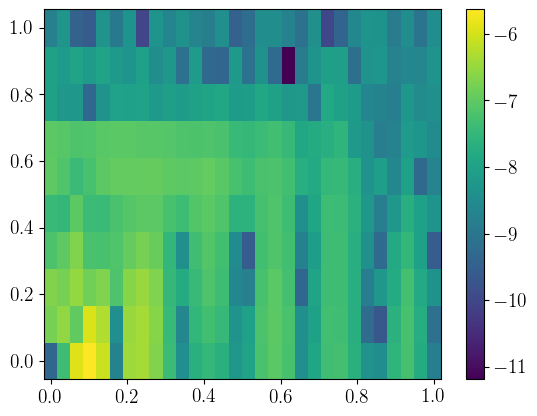

In [533]:
plt.pcolor(alphaA[:, 0], chiA[0, :], np.log10(np.abs(psilm_sample_22-outphase_22)))
plt.colorbar()
plt.show()

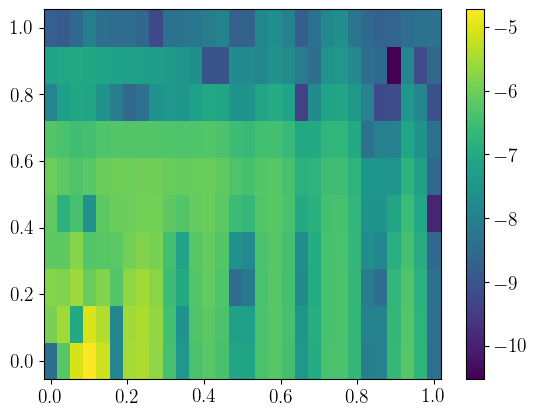

In [534]:
plt.pcolor(alphaA[:, 0], chiA[0, :], np.log10(np.abs(psilm_sample_2020-outphase_2020)))
plt.colorbar()
plt.show()

In [535]:
Alm_sample_22 = np.array([[np.exp(magLMSpline[(2,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_52 = np.array([[np.exp(magLMSpline[(5,2)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_55 = np.array([[np.exp(magLMSpline[(5,5)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])
Alm_sample_2020 = np.array([[np.exp(magLMSpline[(20,20)](chi, alpha)) for alpha in alphaTemp] for chi in chiTemp])

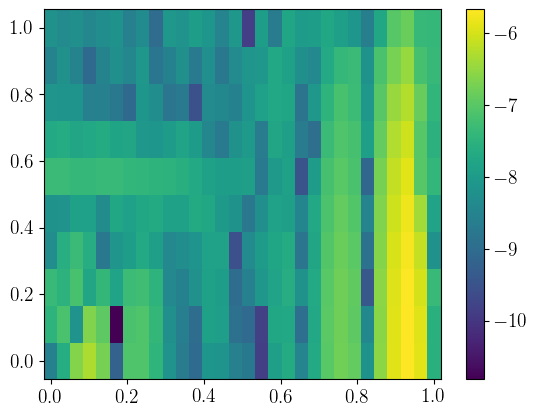

In [536]:
plt.pcolor(alphaA[:, 0], chiA[0, :], np.log10(np.abs(1-Alm_sample_22/output_22)))
plt.colorbar()
plt.show()

In [537]:
alpha_amp_samples = np.linspace(0, 1, 500)
spin_amp_samples = np.array([0.9999, 0.995, 0.99, 0.98, 0.95, 0.9, 0.8])
ALPHA_AMP, SPIN_AMP = np.meshgrid(alpha_amp_samples, spin_amp_samples)
OMEGA_AMP = omega_of_a_alpha(SPIN_AMP, ALPHA_AMP)

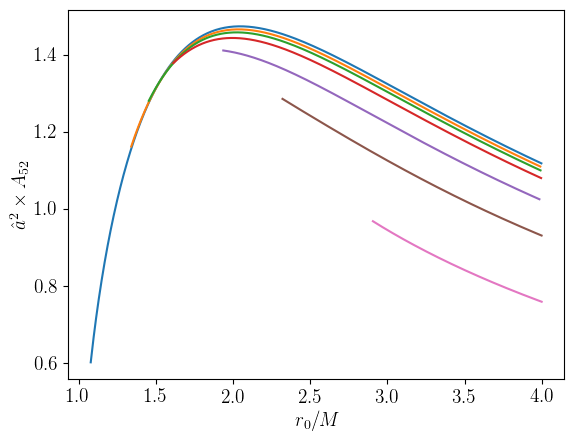

In [538]:
for ii, a in enumerate(spin_amp_samples):
    radius_amp_samples = kerr_circ_geo_radius(a, OMEGA_AMP[ii])
    mag_amp_samples = np.array([np.exp(magLMSpline[(2,2)](chi_of_spin(a), alpha)) for alpha in alpha_amp_samples])
    mag_amp_samples = mag_amp_samples[radius_amp_samples < 4]
    radius_amp_samples = radius_amp_samples[radius_amp_samples < 4]
    plt.plot(radius_amp_samples, a**2*mag_amp_samples)
plt.xlabel('$r_0/M$')
plt.ylabel('$\hat{a}^2 \\times A_{52}$')
plt.show()

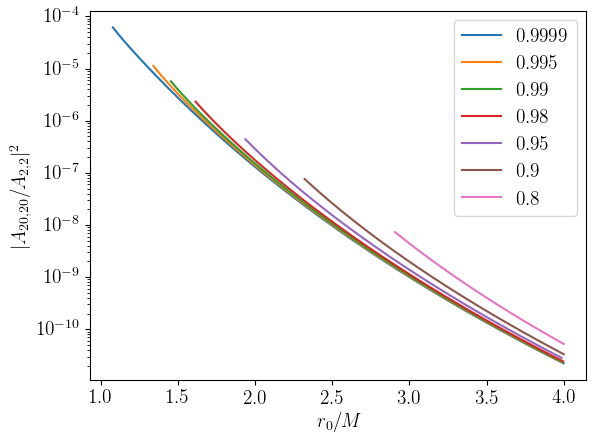

In [539]:
for ii, a in enumerate(spin_amp_samples):
    radius_amp_samples = kerr_circ_geo_radius(a, OMEGA_AMP[ii])
    mag_amp_samples = np.array([np.exp(magLMSpline[(20,20)](chi_of_spin(a), alpha)) for alpha in alpha_amp_samples])/np.array([np.exp(magLMSpline[(2,2)](chi_of_spin(a), alpha)) for alpha in alpha_amp_samples])
    mag_amp_samples = mag_amp_samples[radius_amp_samples < 4]
    radius_amp_samples = radius_amp_samples[radius_amp_samples < 4]
    plt.plot(radius_amp_samples, mag_amp_samples**2, label = str(a))
plt.xlabel('$r_0/M$')
plt.ylabel('$|A_{20,20}/A_{2,2}|^2$')
plt.yscale('log')
plt.legend()
plt.show()

In [116]:
def frequency_evolution_2(M, mu, a, omega_i, Tobs, sampleNum):
    epsilon = mu/M
    # Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    t_i = time_of_a_omega(a, omega_i)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    if t_f > 0:
        t_f = 0
    time_samples = np.linspace(t_i, t_f, sampleNum)
    omega_samples = np.array([omega_test(a, t) for t in time_samples])
    return np.linspace(0, (t_f - t_i)*M_yrs/epsilon, sampleNum), omega_samples

def frequency_evolution_ISCO(M, mu, a, Tobs, sampleNum):
    epsilon = mu/M
    # Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = -0.1
    t_i = t_f  - deltaT
    time_samples = np.linspace(t_i, t_f, sampleNum)
    omega_samples = np.array([omega_test(a, t) for t in time_samples])
    return np.linspace(0, (t_f - t_i)*M_yrs/epsilon, sampleNum), omega_samples

def frequency_evolution_ISCO_df(M, mu, a, Tobs, sampleNum):
    epsilon = mu/M
    # Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = -0.1
    t_i = t_f  - deltaT
    omega_samples = np.linspace(omega_test(a, t_i), omega_test(a, t_f), sampleNum)
    time_samples = np.array([time_of_a_omega(a, omega) for omega in omega_samples])
    return np.diff(time_samples), omega_samples[1:]

In [117]:
freq_test = frequency_evolution_2(1e6, 1e1, 0.9999, kerr_circ_geo_orbital_frequency(0.9999, 5.6), 0.5, 400)
print(freq_test[0][-1])
pow22=np.array([np.exp(magLMSpline[(2,2)](chi_of_spin(0.9999), alpha))**2 for alpha in alpha_of_a_omega(0.9999, freq_test[1])])
pow1515=np.array([np.exp(magLMSpline[(15,15)](chi_of_spin(0.9999), alpha))**2 for alpha in alpha_of_a_omega(0.9999, freq_test[1])])
pow2020=np.array([np.exp(magLMSpline[(20,20)](chi_of_spin(0.9999), alpha))**2 for alpha in alpha_of_a_omega(0.9999, freq_test[1])])

0.4999999999999999


In [118]:
def mode_selection_test(M, mu, a, T, epsilon, sampleNum = 2000):
    freq_test = frequency_evolution_ISCO_df(M, mu, a, T, sampleNum)
    l = 2
    modes = []
    powLM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(l,1)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
    powTot = powLM
    #print(l, 1, powLM, powTot)
    modes.append([l, 1])
    powLM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(l,2)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
    powTot += powLM
    modes.append([l, 2])
    #print(l, 2, powLM, powTot)
    while powLM > epsilon*powTot and l <= 20:
        l += 1
        powLM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(l,1)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
        powTot += powLM
        if powLM > epsilon*powTot:
            modes.append([l, 1])
        #print(l, 1, powLM, powTot)
        powLM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(l,2)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
        powTot += powLM
        if powLM > epsilon*powTot:
            modes.append([l, 2])
        #print(l, 2, powLM, powTot)
    
    powMM = 1
    m = 3
    while powMM > epsilon*powTot and m <= 20:
        powMM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(m,m)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
        powTot += powMM
        #print(m, m, powMM, powTot)
        if powMM > epsilon*powTot:
            modes.append([m, m])
            powLM = 1
            l = m + 1
            while powLM > epsilon*powTot and l <= 20:
                powLM = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(l,m)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
                powTot += powLM
                #print(l, m, powLM, powTot)
                if powLM > epsilon*powTot:
                    modes.append([l, m])
                l += 1
        m += 1

    pow2020 = np.sum(freq_test[0]*np.array([np.exp(magLMSpline[(20,20)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
    # plt.plot(freq_test[0]*np.array([np.exp(magLMSpline[(20,20)](chi_of_spin(a), alpha))**2 for alpha in alpha_of_a_omega(a, freq_test[1])]))
    # plt.yscale('log')
    # plt.show()
    # print(pow2020, powTot)
    return modes, pow2020/powTot

In [119]:
mode_selection_test(1e6, 1e1, 0.9999, 0.5, 1e-5, sampleNum = 500)[1]

3.676404561681112e-07

In [120]:
# len(mode_selection_test(1e5, 1e1, 0.9999, 0.5, 1e-7, sampleNum = 500)[0])
len(mode_selection_test(1e6, 1e1, 0.9999, 0.5, 1e-5, sampleNum = 500)[0])

23

## Scratch

In [153]:
betaPhaseExponent = 1
phiNorm2 = np.log1p(-phaseBetaData)**(1/betaPhaseExponent)
# phiNorm2 = (1-phaseBetaData)**(-3/8)

In [154]:
phi_spl={}
phi_spl[0] = BicubicSpline(chiData, betaData, phiNorm2)
phi_spl[1] = BicubicSpline(chiData[::2], betaData[::2], phiNorm2[::2, ::2])
phi_spl[2] = BicubicSpline(chiData[::4], betaData[::4], phiNorm2[::4, ::4])
phi_spl[3] = BicubicSpline(chiData[::8], betaData[::8], phiNorm2[::8, ::8])
phi_spl[4] = BicubicSpline(chiData[::16], betaData[::16], phiNorm2[::16, ::16])

In [155]:
def phase_of_time(a, t, spl_num = 0):
    chi = chi_of_spin(a)
    beta = beta_of_time(a, t)
    
    return -np.expm1(phi_spl[spl_num](chi, beta)**betaPhaseExponent)

# def phase_of_time(a, t, spl_num = 0):
#     chi = chi_of_spin(a)
#     beta = beta_of_time(a, t)
    
#     return 1-phi_spl[spl_num](chi, beta)**(-8/3)

In [156]:
def omega_min_time_cutoff(a):
    return omega_test(a, time_of_beta(a, 1))

def phase_change_Tobs_2(Tobs, M, mu, a, omega_i, spl_num = 0):
    epsilon = mu/M
    # Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    t_i = time_of_a_omega(a, omega_i, spl_num = spl_num)
    Phi_i = phase_of_time(a, t_i, spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    if t_f > 0:
        t_f = 0
    Phi_f = phase_of_time(a, t_f, spl_num = spl_num)
    return (Phi_f - Phi_i)/epsilon

def phase_change_Tobs(Tobs, M, mu, a, omega_i, spl_num = 0):
    epsilon = mu/M
    Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    t_i = time_of_a_omega(a, omega_i, spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    if t_f > 0:
        t_f = 0
    omega_f = omega_test(a, t_f, spl_num = spl_num)
    Phi_f = phase_of_a_omega(a, omega_f, spl_num = spl_num)
    return (Phi_f - Phi_i)/epsilon

def phase_error_Tobs(Tobs, M, epsilon, a, omega_i, spl_num = 0):
    return phase_change_Tobs(Tobs, M, epsilon, a, omega_i, spl_num = spl_num) - phase_change_Tobs(Tobs, M, epsilon, a, omega_i, spl_num = spl_num + 1)

def phase_error_Tobs_2(Tobs, M, epsilon, a, omega_i, spl_num = 0):
    return phase_change_Tobs_2(Tobs, M, epsilon, a, omega_i, spl_num = spl_num) - phase_change_Tobs_2(Tobs, M, epsilon, a, omega_i, spl_num = spl_num + 1)

In [157]:
def frequency_evolution(M, mu, a, omega_i, Tobs, sampleNum):
    epsilon = mu/M
    # Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    t_i = time_of_a_omega(a, omega_i)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    if t_f > 0:
        t_f = 0
    time_samples = np.linspace(t_i, t_f, sampleNum)
    omega_samples = np.array([omega_test(a, t)/(M*Modot_GC1_to_S) for t in time_samples])
    return np.linspace(0, (t_f - t_i)*M_yrs/epsilon, sampleNum), omega_samples

In [158]:
def omega_initial_estimate(M, mu, a, Tobs):
    epsilon = mu/M
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    ti = -Tobs*epsilon/M_yrs
    alpha = 5./256.
    oISCO = kerr_isco_frequency(a)
    omega = (oISCO**(-8/3) - ti/alpha)**(-3/8)
    return omega

def frequency_estimate(M, mu, a, Tobs):
    omega = omega_initial_estimate(M, mu, a, Tobs)
    return omega/(M*Modot_GC1_to_S)/(np.pi)

def frequency_estimate_2(M, mu, a, Tobs):
    q = mu/M
    eta = q/(1 + q)**2
    MoMSun = M + mu
    alpha = 4.927e-6 # == GNewt*MSun/clight**3, in seconds
    t_merge = Tobs*yr_MKS

    f_GW = (1.0/np.pi)*(alpha*MoMSun)**(-0.625)*(256.0*eta*t_merge/5.0)**(-0.375)

    return f_GW

In [159]:
frequency_estimate(1e7, 1e0, 0.9, 1/12), omega_initial_estimate(5e5, 1e1, 0.9, 2)

(0.0014541153668542598, 0.022005815281894298)

In [160]:
Msample = 1e5
musample = 1e1
spinsample = 0.9
times = [1/365, 1/365]
print(np.sqrt(frequency_estimate(Msample, musample, spinsample, times[0])*frequency_estimate(Msample, musample, spinsample, times[1])))
print(np.sqrt(frequency_estimate_2(Msample, musample, spinsample, times[0])*frequency_estimate_2(Msample, musample, spinsample, times[1])))

0.04936671776540911
0.05043223536164675


In [161]:
times = [0.001, 0.001]
print(np.sqrt(frequency_estimate(Msample, musample, spinsample, times[0])*frequency_estimate(Msample, musample, spinsample, times[1])))

0.06958001734319164


In [162]:
frequency_estimate(5e5, 1e1, 0.9, 2), omega_initial_estimate(1e8, 1e2, 0.9, 1)

(0.002844251925358608, 0.22043206008345237)

In [163]:
frequency_estimate(1e8, 1e2, 0.9, 1)

0.0001424542338631213

In [164]:
kerr_isco_frequency(0.9)

0.22544170883530798

In [165]:
ts, os = frequency_evolution(1e8, 1e2, 0.9, 0.205, 1, 200)
print(ts[-1])

1.0


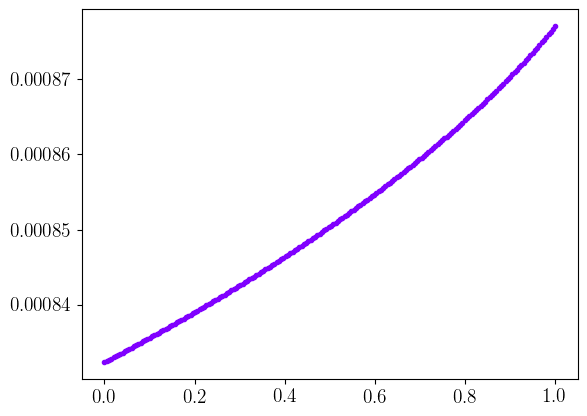

In [166]:
plt.plot(ts, 2*os, '.')
plt.show()

In [233]:
from scipy.integrate import solve_ivp
ISCOWEIGHT = 0.995
def dJdTIntegrate(t, alphaVec, a_val):
    alpha = alphaVec[0]
    oISCO_val = kerr_isco_frequency(a_val)
    omega = omega_of_a_alpha(a_val, alpha)
    if omega >= ISCOWEIGHT*oISCO_val:
        return [0., 0.]
    dOmega_dAlpha = omega_alpha_derivative(omega, oISCO_val)
    dE_dOmega = energy_omega_derivative(a_val, omega)
    chi_val = chi_of_spin(a_val)
    Edot = flux_spl(chi_val, alpha)*pn_flux_noprefactor(omega)
    return np.array([-1./(dE_dOmega*dOmega_dAlpha/Edot), omega])

def phase_test_integration(Tobs, M, mu, a, omega0):
    epsilon = mu/M
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    alpha0 = alpha_of_a_omega(a, omega0)
    insp = solve_ivp(dJdTIntegrate, [0, deltaT], [alpha0, 0.], args=(a,), method='DOP853', t_eval=None, rtol=1.e-13, atol = 1.e-10)
    return insp.y[1][-1]/epsilon

In [254]:
from scipy.integrate import solve_ivp
def phase_test_integration_2(Tobs, M, mu, a, omega0):
    if not isinstance(Tobs, np.ndarray) and not isinstance(Tobs, list):
        return phase_test_integration(Tobs, M, mu, a, omega0)
    
    epsilon = mu/M
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    alpha0 = alpha_of_a_omega(a, omega0)
    deltaT = np.array(deltaT)
    insp = solve_ivp(dJdTIntegrate, [0, 2*deltaT[-1]], [alpha0, 0.], args=(a,), method='RK45', t_eval=deltaT, rtol=1.e-12, atol = 1.e-10)
    if not insp.success:
        insp = solve_ivp(dJdTIntegrate, [0, 4*deltaT[-1]], [alpha0, 0.], args=(a,), method='RK45', t_eval=deltaT, rtol=1.e-9, atol = 1.e-8)
    phase = np.ones(deltaT.shape[0])*insp.y[1][-1]/epsilon
    if deltaT.shape[0] != insp.y[1].shape[0]:
        print("Requested time samples not the correct length")
        print(insp.y[1].shape[0], deltaT.shape[0])
        print(omega_of_a_alpha(a, insp.y[0][-1]))
    phase[:insp.y[1].shape[0]] = insp.y[1]/epsilon
    return phase

def phase_change_Tobs_3(Tobs, M, mu, a, omega_i, spl_num = 0):
    epsilon = mu/M
    t_i = time_of_a_omega(a, omega_i, spl_num = spl_num)
    t_ISCO = time_of_a_omega(a, ISCOWEIGHT*kerr_isco_frequency(a), spl_num = spl_num)
    Phi_i = phase_of_time(a, t_i, spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    t_f[t_f > t_ISCO] = t_ISCO
    Phi_f = np.array([phase_of_time(a, t, spl_num = spl_num) for t in t_f])
    return (Phi_f - Phi_i)/epsilon

def phase_change_Tobs_4(Tobs, M, mu, a, omega_i, spl_num = 0):
    epsilon = mu/M
    Phi_i = phase_of_a_omega(a, omega_i, spl_num = spl_num)
    t_i = time_of_a_omega(a, omega_i, spl_num = spl_num)
    t_ISCO = time_of_a_omega(a, ISCOWEIGHT*kerr_isco_frequency(a), spl_num = spl_num)
    M_yrs = M*Modot_GC1_to_S/yr_MKS
    deltaT = Tobs*epsilon/M_yrs
    t_f = t_i + deltaT
    t_f[t_f > t_ISCO] = t_ISCO
    omega_f = np.array([omega_test(a, t, spl_num = spl_num) for t in t_f])
    Phi_f = np.array([phase_of_a_omega(a, omega, spl_num = spl_num) for omega in omega_f])
    return (Phi_f - Phi_i)/epsilon

In [255]:
def phase_compare_integration(M, mu, a, t_array = np.linspace(0.05, 50, 10)):
    frequencyWindow = np.logspace(np.log10(0.0022), np.log10(0.95*kerr_isco_frequency(a)), 17)
    return np.array([np.abs(phase_change_Tobs_3(np.array(t_array), M, mu, a, omega, spl_num = 0) - phase_test_integration_2(np.array(t_array), M, mu, a, omega)) for omega in frequencyWindow])

def phase_compare_integration_high_frequency(M, mu, a, t_array = np.linspace(0.05, 50, 10)):
    frequencyWindow = np.logspace(np.log10(0.013), np.log10(0.95*kerr_isco_frequency(a)), 17)
    return np.array([np.abs(phase_change_Tobs_3(np.array(t_array), M, mu, a, omega, spl_num = 0) - phase_test_integration_2(np.array(t_array), M, mu, a, omega)) for omega in frequencyWindow])

def phase_compare_integration_2(M, mu, a, t_array = np.linspace(0.05, 50, 10)):
    frequencyWindow = np.logspace(np.log10(0.0022), np.log10(0.95*kerr_isco_frequency(a)), 17)
    return np.array([np.abs(phase_change_Tobs_4(np.array(t_array), M, mu, a, omega, spl_num = 0) - phase_test_integration_2(np.array(t_array), M, mu, a, omega)) for omega in frequencyWindow])

In [188]:
def phase_difference_error(M, mu, a, spl_num = 0, tMax = 50):
    timeWindow = np.linspace(0.05, tMax, 200)
    frequencyWindow = np.logspace(np.log10(0.0022), np.log10(0.95*kerr_isco_frequency(a)), 17)
    return np.array([[np.abs(phase_error_Tobs_2(t, M, mu, a, omega, spl_num = spl_num)) for t in timeWindow] for omega in frequencyWindow])

In [189]:
# def phase_difference_error_estimate(M, mu, a, tMax = 25):
#     timeWindow = np.linspace(0.05, tMax, 100)
#     frequencyWindow = np.logspace(np.log10(0.0021), np.log10(0.99*kerr_isco_frequency(a)), 17)
#     test0 = np.array([[np.abs(phase_error_Tobs_2(t, M, mu, a, omega, spl_num = 0)) for t in timeWindow] for omega in frequencyWindow])
#     test1 = np.array([[np.abs(phase_error_Tobs_2(t, M, mu, a, omega, spl_num = 1)) for t in timeWindow] for omega in frequencyWindow])
#     test2 = np.array([[np.abs(phase_error_Tobs_2(t, M, mu, a, omega, spl_num = 2)) for t in timeWindow] for omega in frequencyWindow])
#     test3 = np.array([[np.abs(phase_error_Tobs_2(t, M, mu, a, omega, spl_num = 3)) for t in timeWindow] for omega in frequencyWindow])
#     errorRatio0 = np.empty(test0.shape)
#     errorRatio1 = np.empty(test0.shape)
#     testEstimate = np.empty(test0.shape)
#     conservativeError = np.empty(test0.shape)
#     for i in range(test0.shape[0]):
#         for j in range(test0.shape[1]):
#             errorRatio0[i, j] = test1[i, j]/test0[i, j]
#             errorRatio1[i, j] = test2[i, j]/test1[i, j]
#             conservativeError[i, j] = errorRatio0[i, j]
#             if errorRatio0[i, j] < errorRatio1[i, j]:
#                 conservativeError[i, j] = errorRatio0[i, j]*errorRatio0[i, j]/errorRatio1[i, j]
#             if conservativeError[i, j] < 1:
#                 conservativeError[i, j] = 1
#     testEstimate = test0/conservativeError
#     return test0, test1, test2, test3, conservativeError

In [190]:
spinWindow = -0.999*np.cos(np.linspace(0, np.pi/2, 5))**(1/3)
spinWindow = np.concatenate([spinWindow, -np.flip(spinWindow[:-1])])

In [191]:
time_spans = [0.5, 2, 5, 10, 25]
mass_ratio_list_range = [1e2, 1e7]
mass_ratio_list = np.logspace(np.log10(mass_ratio_list_range[0]), np.log10(mass_ratio_list_range[1]), 11)
M_list_range = [1e4, 1e8]
M_list = np.logspace(np.log10(M_list_range[0]), np.log10(M_list_range[1]), 9)

In [198]:
spinWindow

array([-9.99000000e-01, -9.72980053e-01, -8.90007819e-01, -7.25290588e-01,
       -3.93754721e-06,  7.25290588e-01,  8.90007819e-01,  9.72980053e-01,
        9.99000000e-01])

In [256]:
spinTests = {}
for mass_ratio in mass_ratio_list:
    for M in M_list:
        if M/mass_ratio >= 1:
            print(M, M/mass_ratio)
            tmp =np.array([phase_compare_integration(M, M/mass_ratio, a, t_array = time_spans) for a in spinWindow])
            spinTests[(M, M/mass_ratio)] = np.array([phase_compare_integration(M, M/mass_ratio, a, t_array = time_spans) for a in spinWindow])

10000.0 100.0
31622.776601683792 316.2277660168379
100000.0 1000.0
316227.7660168379 3162.277660168379
1000000.0 10000.0
3162277.6601683795 31622.776601683796
10000000.0 100000.0
31622776.60168379 316227.7660168379
100000000.0 1000000.0
10000.0 31.62277660168379
31622.776601683792 99.99999999999999
100000.0 316.2277660168379
316227.7660168379 999.9999999999999
1000000.0 3162.277660168379
3162277.6601683795 10000.0
10000000.0 31622.776601683792
31622776.60168379 99999.99999999999
100000000.0 316227.7660168379
10000.0 10.0
31622.776601683792 31.622776601683793
100000.0 100.0
316227.7660168379 316.2277660168379
1000000.0 1000.0
3162277.6601683795 3162.2776601683795
10000000.0 10000.0
31622776.60168379 31622.776601683792
100000000.0 100000.0
10000.0 3.162277660168379
31622.776601683792 10.0
100000.0 31.622776601683793
316227.7660168379 99.99999999999999
1000000.0 316.2277660168379
3162277.6601683795 1000.0
10000000.0 3162.277660168379
31622776.60168379 9999.999999999998
100000000.0 31622.7

In [257]:
spinTestsSubset = {}
for mass_ratio in mass_ratio_list:
    for M in M_list:
        if M/mass_ratio >= 1:
            print(M, M/mass_ratio)
            spinTestsSubset[(M, M/mass_ratio)] = np.array([phase_compare_integration_high_frequency(M, M/mass_ratio, a, t_array = time_spans) for a in spinWindow])

10000.0 100.0
31622.776601683792 316.2277660168379
100000.0 1000.0
316227.7660168379 3162.277660168379
1000000.0 10000.0
3162277.6601683795 31622.776601683796
10000000.0 100000.0
31622776.60168379 316227.7660168379
100000000.0 1000000.0
10000.0 31.62277660168379
31622.776601683792 99.99999999999999
100000.0 316.2277660168379
316227.7660168379 999.9999999999999
1000000.0 3162.277660168379
3162277.6601683795 10000.0
10000000.0 31622.776601683792
31622776.60168379 99999.99999999999
100000000.0 316227.7660168379
10000.0 10.0
31622.776601683792 31.622776601683793
100000.0 100.0
316227.7660168379 316.2277660168379
1000000.0 1000.0
3162277.6601683795 3162.2776601683795
10000000.0 10000.0
31622776.60168379 31622.776601683792
100000000.0 100000.0
10000.0 3.162277660168379
31622.776601683792 10.0
100000.0 31.622776601683793
316227.7660168379 99.99999999999999
1000000.0 316.2277660168379
3162277.6601683795 1000.0
10000000.0 3162.277660168379
31622776.60168379 9999.999999999998
100000000.0 31622.7

In [258]:
phase_diff = {}
for j, time_span in enumerate(time_spans):
    temp_array = np.zeros((len(mass_ratio_list), len(M_list)))
    for ii, mass_ratio in enumerate(mass_ratio_list):
        for jj, M in enumerate(M_list):
            if M/mass_ratio >= 1:
                temp_array[ii, jj] = np.max(spinTests[(M, M/mass_ratio)], axis = (0,1))[j]
    temp_array[temp_array==0] = None
    phase_diff[time_span] = temp_array

In [259]:
phase_diff_2 = {}
for j in range(len(time_spans)):
    time_span = time_spans[j]
    temp_array = np.zeros((len(mass_ratio_list), len(M_list)))
    for ii in range(temp_array.shape[0]):
        mass_ratio = mass_ratio_list[ii]
        for jj in range(temp_array.shape[1]):
            M = M_list[jj]
            if M/mass_ratio >= 2:
                temp_array[ii, jj] = np.max(spinTestsSubset[(M, M/mass_ratio)], axis = (0,1))[j]
            else:
                temp_array[ii, jj] = None
    # temp_array[temp_array==0] = None
    # if time_span == 5:
    #     print(np.log10(temp_array))
    phase_diff_2[time_span] = temp_array

In [260]:
_, Z = np.meshgrid(-np.log10(mass_ratio_list), np.log10(M_list))

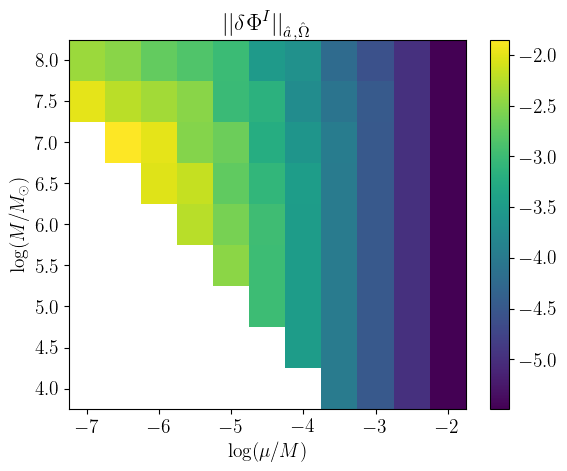

In [270]:
plt.pcolormesh(-np.log10(mass_ratio_list), np.log10(M_list), np.log10(phase_diff_2[5].T), shading='auto')
# plt.plot(-np.log10(mass_ratio_list), Z.T, '.')
plt.colorbar()
plt.show()

In [298]:
for ii, Tobs in enumerate(time_spans):
    print(np.nanmin(np.log10(phase_diff[Tobs].T)))
    print(np.nanmax(np.log10(phase_diff[Tobs].T)))

-5.0125239674462385
-2.0125239680154015
-4.797144252442384
-1.729721789479348
-4.703719679700545
-1.5125239671434587
-4.715784189695827
-1.3660657521651607
-4.763960619134228
-1.1922573856978809


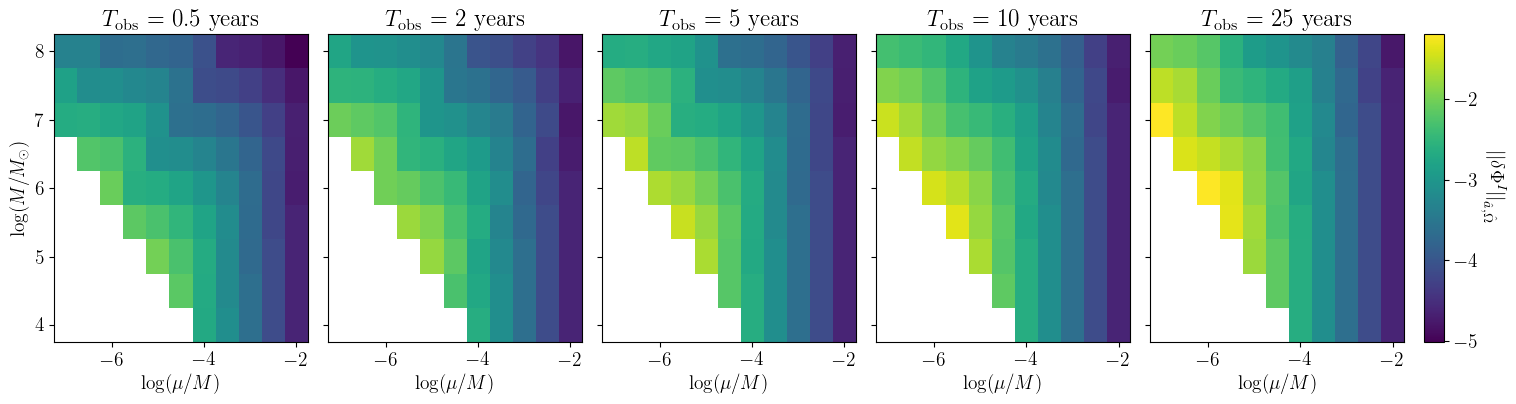

In [340]:
fig, axs = plt.subplots(1, 5, sharey=True, figsize=(20, 4))
fig.subplots_adjust(wspace=0.08)
vmax = -1.1922573856978809
vmin = -5.0125239674462385
# fig.subplots_adjust(hspace=2)
for ii, Tobs in enumerate(time_spans):
    pcm = axs[ii].pcolormesh(-np.log10(mass_ratio_list), np.log10(M_list), np.log10(phase_diff[Tobs].T), shading='auto', vmin=vmin, vmax=vmax)
    # title_string = '$||\delta \Phi^I||_{\hat{{a}},\hat{{\Omega}}}$ for $T_\mathrm{obs}$ = ' + (f"{Tobs} years")
    title_string = '$T_\mathrm{obs}$ = ' + (f"{Tobs} years")
    axs[ii].set_title(title_string)
    axs[ii].set_xlabel("$\log (\mu/M)$")

axs[0].set_ylabel("$\log (M/M_\odot)$")
# plt.plot(-np.log10(mass_ratio_list), Z.T, '.')
fig.subplots_adjust(right=0.8)
colorbar_axes = fig.add_axes([0.81, 0.11, 0.01, 0.77])
cbar = fig.colorbar(pcm, cax=colorbar_axes)
cbar.ax.get_yaxis().labelpad = 20
cbar.ax.set_ylabel("$||\\delta\\Phi^I||_{\\hat{a},\\hat{\\Omega}}$", rotation=270)
plt.savefig("../figures/deltaPhiTest.pdf", bbox_inches='tight')

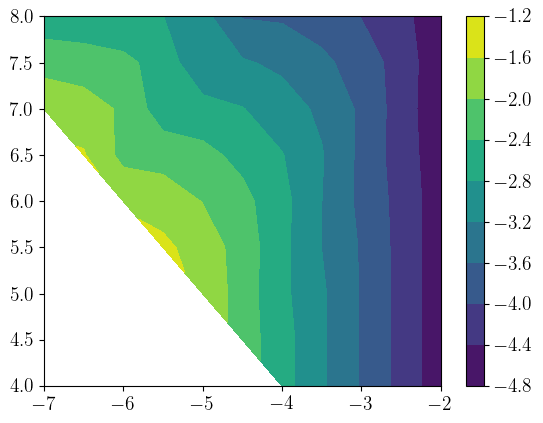

In [265]:
_, Z = np.meshgrid(-np.log10(mass_ratio_list), np.log10(M_list))
plt.contourf(-np.log10(mass_ratio_list), np.log10(M_list), np.log10(phase_diff[5].T), alpha = 1.)
# plt.plot(-np.log10(mass_ratio_list), Z.T, 'k.')
plt.colorbar()
plt.show()

In [303]:
[10**np.nanmax(np.log10(phase_diff_2[tt].T))/10**np.nanmax(np.log10(phase_diff[tt].T)) for tt in time_spans]

[0.4617372325841937,
 0.4962557323985617,
 0.46173723150951473,
 0.5963638470363478,
 0.4480227063067279]

In [301]:
[10**np.nanmax(np.log10(phase_diff[tt].T)) for tt in time_spans]

[0.009715743304695938,
 0.01863280378165655,
 0.030723878066055484,
 0.043046143371611834,
 0.06423069396987557]

In [302]:
[10**np.nanmax(np.log10(phase_diff_2[tt].T)) for tt in time_spans]

[0.004486120426008711,
 0.00924663568730466,
 0.014186358399456363,
 0.025671163661172617,
 0.028776809340342883]